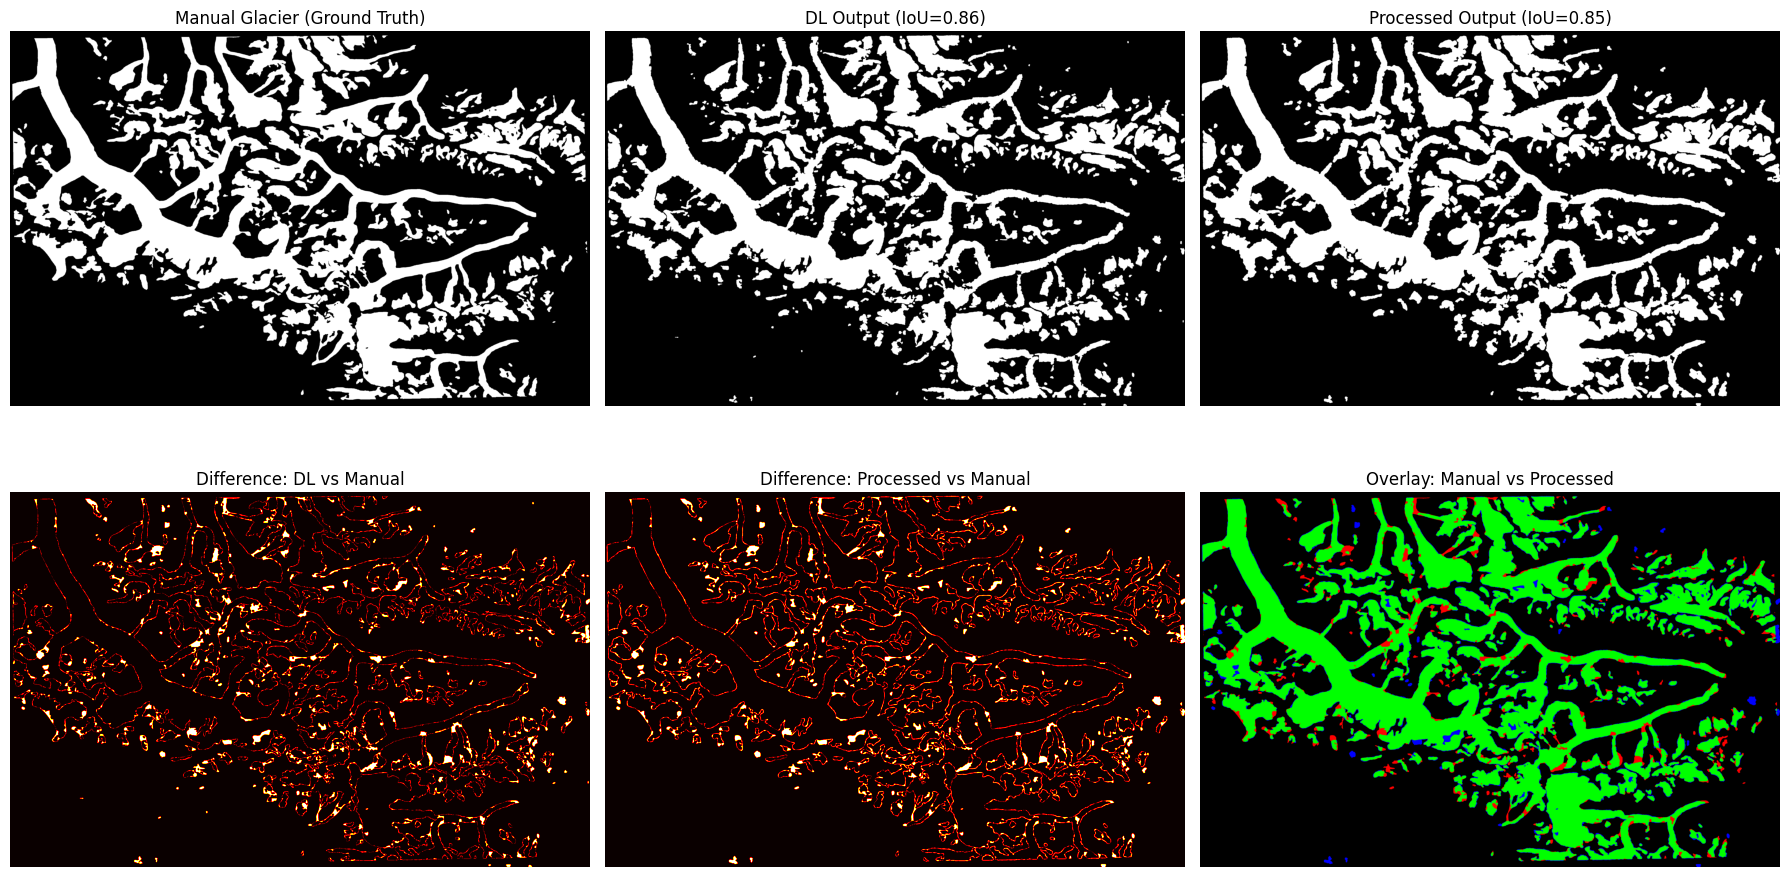

In [11]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_erosion, label, distance_transform_edt
from skimage.morphology import remove_small_objects, closing, disk
from rasterio.warp import reproject, Resampling
import os

# === Parameters ===
manual_raster = "Z:/objective-1/original_mask/satopanth_mask.tif"  # Manual ground truth
input_raster = "Z:/objective-1/sfs_results/post_processing/saunet_6_satopanth.tif"
output_raster = "Z:/objective-1/sfs_results/post_processing/using_python/sato_saunet_processed.tif"
min_area_km2 = 0.03
merge_distance_m = 20
pixel_resolution = 10

# === Step 1: Load and resample manual mask to match DL raster ===
with rasterio.open(manual_raster) as manual_src:
    manual_mask_orig = manual_src.read(1).astype(np.uint8)
    manual_transform = manual_src.transform
    manual_crs = manual_src.crs

with rasterio.open(input_raster) as src:
    glacier_mask = src.read(1).astype(bool)
    profile = src.profile
    transform = src.transform
    input_shape = glacier_mask.shape
    input_crs = src.crs

# Reproject manual mask to match DL raster shape and transform
manual_mask_resampled = np.zeros(input_shape, dtype=np.uint8)

reproject(
    source=manual_mask_orig,
    destination=manual_mask_resampled,
    src_transform=manual_transform,
    src_crs=manual_crs,
    dst_transform=transform,
    dst_crs=input_crs,
    resampling=Resampling.nearest
)

manual_mask = manual_mask_resampled > 0

# === Step 2: Remove Small Objects ===
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
cleaned_mask = remove_small_objects(glacier_mask, min_size=min_area_pixels)

# === Step 3: Merge Close Regions ===
distance = distance_transform_edt(~cleaned_mask)
merge_mask = distance <= (merge_distance_m / pixel_resolution)
dilated_mask = np.logical_or(cleaned_mask, merge_mask)
filled_mask = binary_dilation(dilated_mask, structure=np.ones((3, 3)))
filled_mask = binary_erosion(filled_mask, structure=np.ones((3, 3)))

# === Step 4: Smooth Edges ===
smooth_mask = closing(filled_mask, disk(2))

# === Step 5: Save Processed Mask ===
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(smooth_mask.astype(np.uint8), 1)

# === Step 6: Compute IoU Metrics ===
def compute_iou(pred, true):
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    return intersection / union if union > 0 else 0.0

iou_dl = compute_iou(glacier_mask, manual_mask)
iou_processed = compute_iou(smooth_mask, manual_mask)

# === Step 7: Plot Results ===
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: masks
axs[0, 0].imshow(manual_mask, cmap='gray')
axs[0, 0].set_title("Manual Glacier (Ground Truth)")

axs[0, 1].imshow(glacier_mask, cmap='gray')
axs[0, 1].set_title(f"DL Output (IoU={iou_dl:.2f})")

axs[0, 2].imshow(smooth_mask, cmap='gray')
axs[0, 2].set_title(f"Processed Output (IoU={iou_processed:.2f})")

# Row 2: differences and overlay
diff_dl = np.logical_xor(manual_mask, glacier_mask)
diff_processed = np.logical_xor(manual_mask, smooth_mask)

overlay = np.zeros((*manual_mask.shape, 3), dtype=np.uint8)
overlay[manual_mask & ~smooth_mask] = [255, 0, 0]   # Red: missed by processed
overlay[~manual_mask & smooth_mask] = [0, 0, 255]   # Blue: false positive
overlay[manual_mask & smooth_mask] = [0, 255, 0]    # Green: true positive

axs[1, 0].imshow(diff_dl, cmap='hot')
axs[1, 0].set_title("Difference: DL vs Manual")

axs[1, 1].imshow(diff_processed, cmap='hot')
axs[1, 1].set_title("Difference: Processed vs Manual")

axs[1, 2].imshow(overlay)
axs[1, 2].set_title("Overlay: Manual vs Processed")

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()
plt.show()

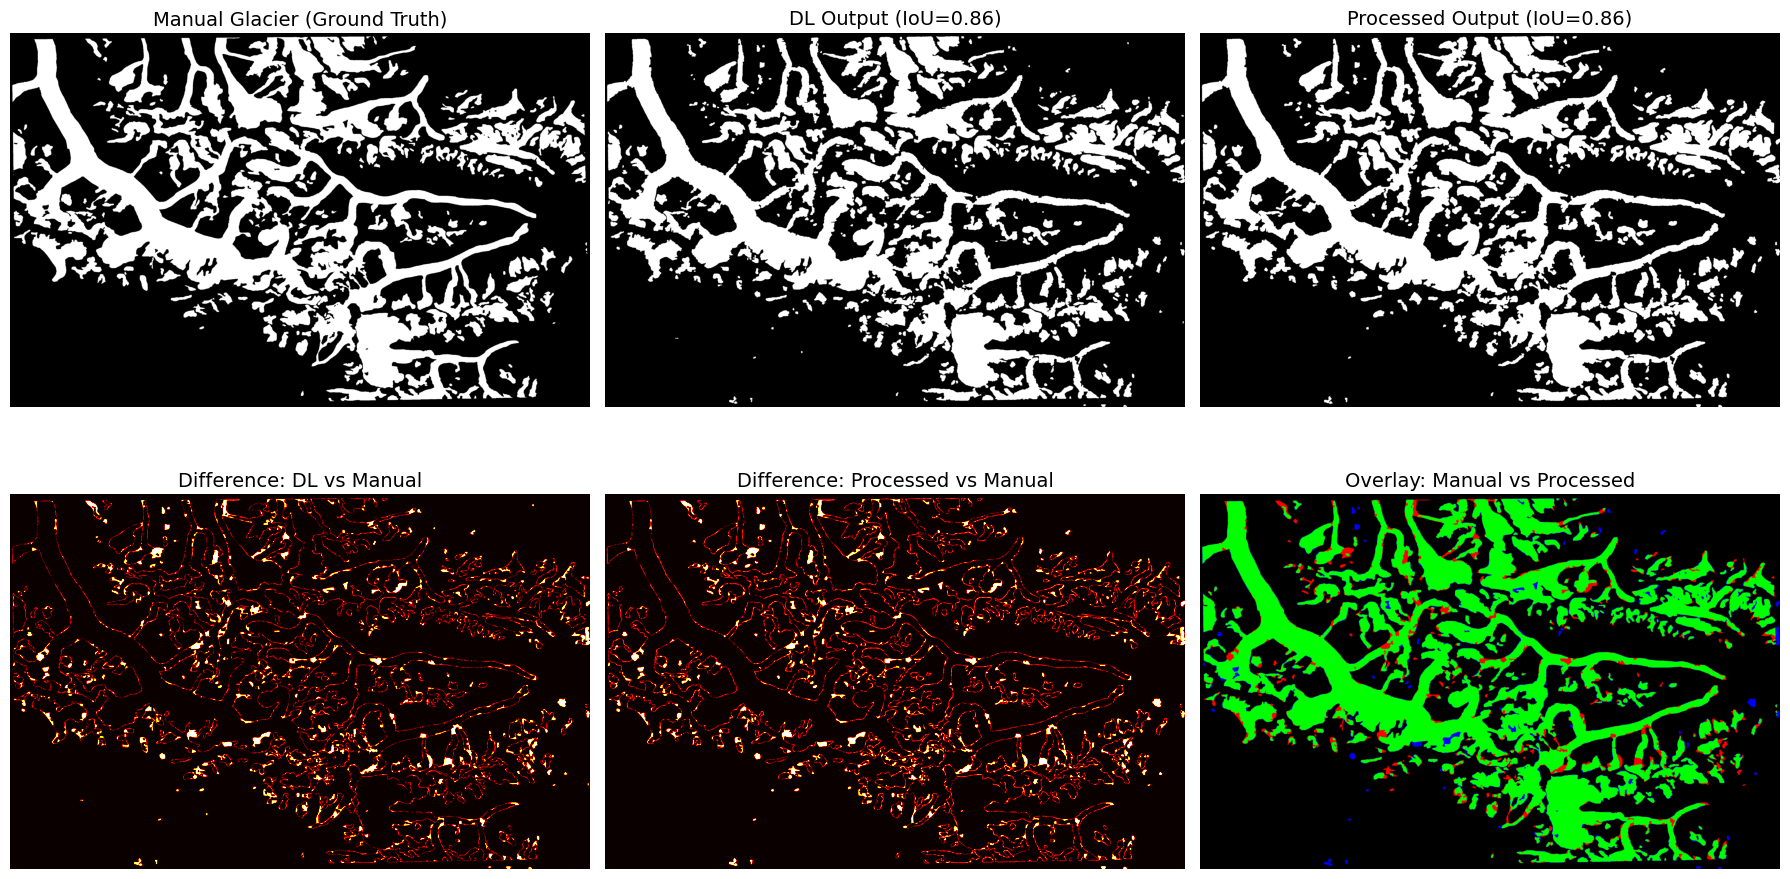

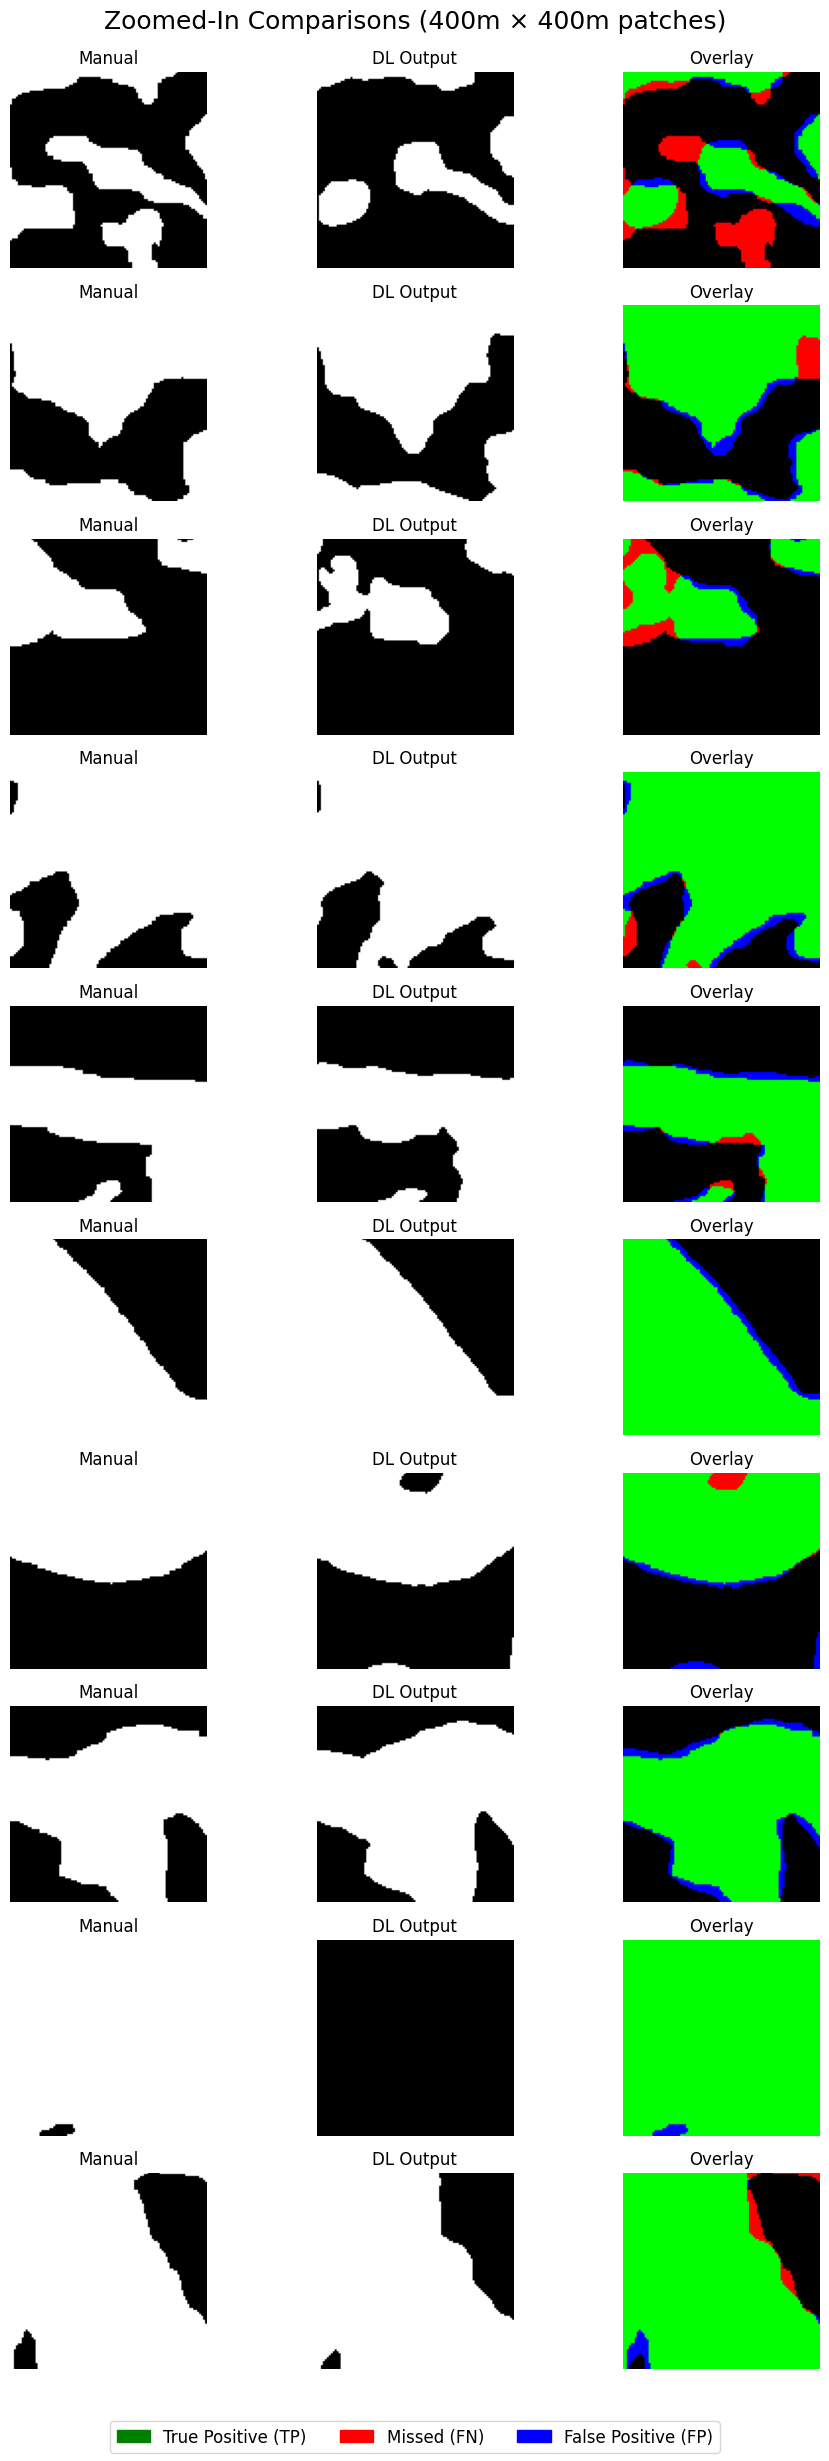

In [14]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_erosion, label, distance_transform_edt
from skimage.morphology import remove_small_objects, closing, disk
from rasterio.warp import reproject, Resampling
import matplotlib.patches as mpatches

# === Parameters ===
manual_raster = "Z:/objective-1/original_mask/satopanth_mask.tif"
input_raster = "Z:/objective-1/sfs_results/post_processing/saunet_6_satopanth.tif"
output_raster = "Z:/objective-1/sfs_results/post_processing/using_python/sato_saunet_processed.tif"
min_area_km2 = 0.02
merge_distance_m = 10
pixel_resolution = 10
window_size = int(1000 / pixel_resolution)  # 400m x 400m window = 40x40 px

# === Step 1: Load and resample manual raster ===
with rasterio.open(manual_raster) as manual_src:
    manual_mask_orig = manual_src.read(1).astype(np.uint8)
    manual_transform = manual_src.transform
    manual_crs = manual_src.crs

with rasterio.open(input_raster) as src:
    glacier_mask = src.read(1).astype(bool)
    profile = src.profile
    transform = src.transform
    input_shape = glacier_mask.shape
    input_crs = src.crs

manual_mask_resampled = np.zeros(input_shape, dtype=np.uint8)
reproject(
    source=manual_mask_orig,
    destination=manual_mask_resampled,
    src_transform=manual_transform,
    src_crs=manual_crs,
    dst_transform=transform,
    dst_crs=input_crs,
    resampling=Resampling.nearest
)
manual_mask = manual_mask_resampled > 0

# === Step 2: Remove small objects ===
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
cleaned_mask = remove_small_objects(glacier_mask, min_size=min_area_pixels)

# === Step 3: Merge close regions ===
distance = distance_transform_edt(~cleaned_mask)
merge_mask = distance <= (merge_distance_m / pixel_resolution)
dilated_mask = np.logical_or(cleaned_mask, merge_mask)
filled_mask = binary_dilation(dilated_mask, structure=np.ones((3, 3)))
filled_mask = binary_erosion(filled_mask, structure=np.ones((3, 3)))

# === Step 4: Smooth edges ===
smooth_mask = closing(filled_mask, disk(2))

# === Step 5: Save processed mask ===
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(smooth_mask.astype(np.uint8), 1)

# === Step 6: Compute IoU ===
def compute_iou(pred, true):
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    return intersection / union if union > 0 else 0.0

iou_dl = compute_iou(glacier_mask, manual_mask)
iou_processed = compute_iou(smooth_mask, manual_mask)

# === Step 7: Plot full masks & differences ===
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Main masks
axs[0, 0].imshow(manual_mask, cmap='gray')
axs[0, 0].set_title("Manual Glacier (Ground Truth)", fontsize=14)

axs[0, 1].imshow(glacier_mask, cmap='gray')
axs[0, 1].set_title(f"DL Output (IoU={iou_dl:.2f})", fontsize=14)

axs[0, 2].imshow(smooth_mask, cmap='gray')
axs[0, 2].set_title(f"Processed Output (IoU={iou_processed:.2f})", fontsize=14)

# Differences and overlay
diff_dl = np.logical_xor(manual_mask, glacier_mask)
diff_processed = np.logical_xor(manual_mask, smooth_mask)
overlay = np.zeros((*manual_mask.shape, 3), dtype=np.uint8)
overlay[manual_mask & ~smooth_mask] = [255, 0, 0]   # Red: missed
overlay[~manual_mask & smooth_mask] = [0, 0, 255]   # Blue: false positive
overlay[manual_mask & smooth_mask] = [0, 255, 0]    # Green: true positive

axs[1, 0].imshow(diff_dl, cmap='hot')
axs[1, 0].set_title("Difference: DL vs Manual", fontsize=14)

axs[1, 1].imshow(diff_processed, cmap='hot')
axs[1, 1].set_title("Difference: Processed vs Manual", fontsize=14)

axs[1, 2].imshow(overlay)
axs[1, 2].set_title("Overlay: Manual vs Processed", fontsize=14)

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()
plt.show()

# === Step 8: Zoomed-in Patches (Random) ===
np.random.seed(42)  # For reproducibility
glacier_indices = np.argwhere(manual_mask)
sample_indices = glacier_indices[np.random.choice(glacier_indices.shape[0], 10, replace=False)]

fig, axes = plt.subplots(10, 3, figsize=(10, 25))
for i, (y, x) in enumerate(sample_indices):
    x1 = max(0, x - window_size // 2)
    y1 = max(0, y - window_size // 2)
    x2 = min(glacier_mask.shape[1], x1 + window_size)
    y2 = min(glacier_mask.shape[0], y1 + window_size)

    axes[i, 0].imshow(manual_mask[y1:y2, x1:x2], cmap='gray')
    axes[i, 0].set_title("Manual")
    
    axes[i, 1].imshow(glacier_mask[y1:y2, x1:x2], cmap='gray')
    axes[i, 1].set_title("DL Output")

    patch_overlay = np.zeros((y2 - y1, x2 - x1, 3), dtype=np.uint8)
    m = manual_mask[y1:y2, x1:x2]
    s = smooth_mask[y1:y2, x1:x2]
    patch_overlay[m & ~s] = [255, 0, 0]    # FN
    patch_overlay[~m & s] = [0, 0, 255]    # FP
    patch_overlay[m & s] = [0, 255, 0]     # TP

    axes[i, 2].imshow(patch_overlay)
    axes[i, 2].set_title("Overlay")

    for ax in axes[i, :]:
        ax.axis('off')

# Add legend
red_patch = mpatches.Patch(color='red', label='Missed (FN)')
blue_patch = mpatches.Patch(color='blue', label='False Positive (FP)')
green_patch = mpatches.Patch(color='green', label='True Positive (TP)')
fig.legend(handles=[green_patch, red_patch, blue_patch], loc='lower center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.suptitle("Zoomed-In Comparisons (400m × 400m patches)", fontsize=18)
plt.show()


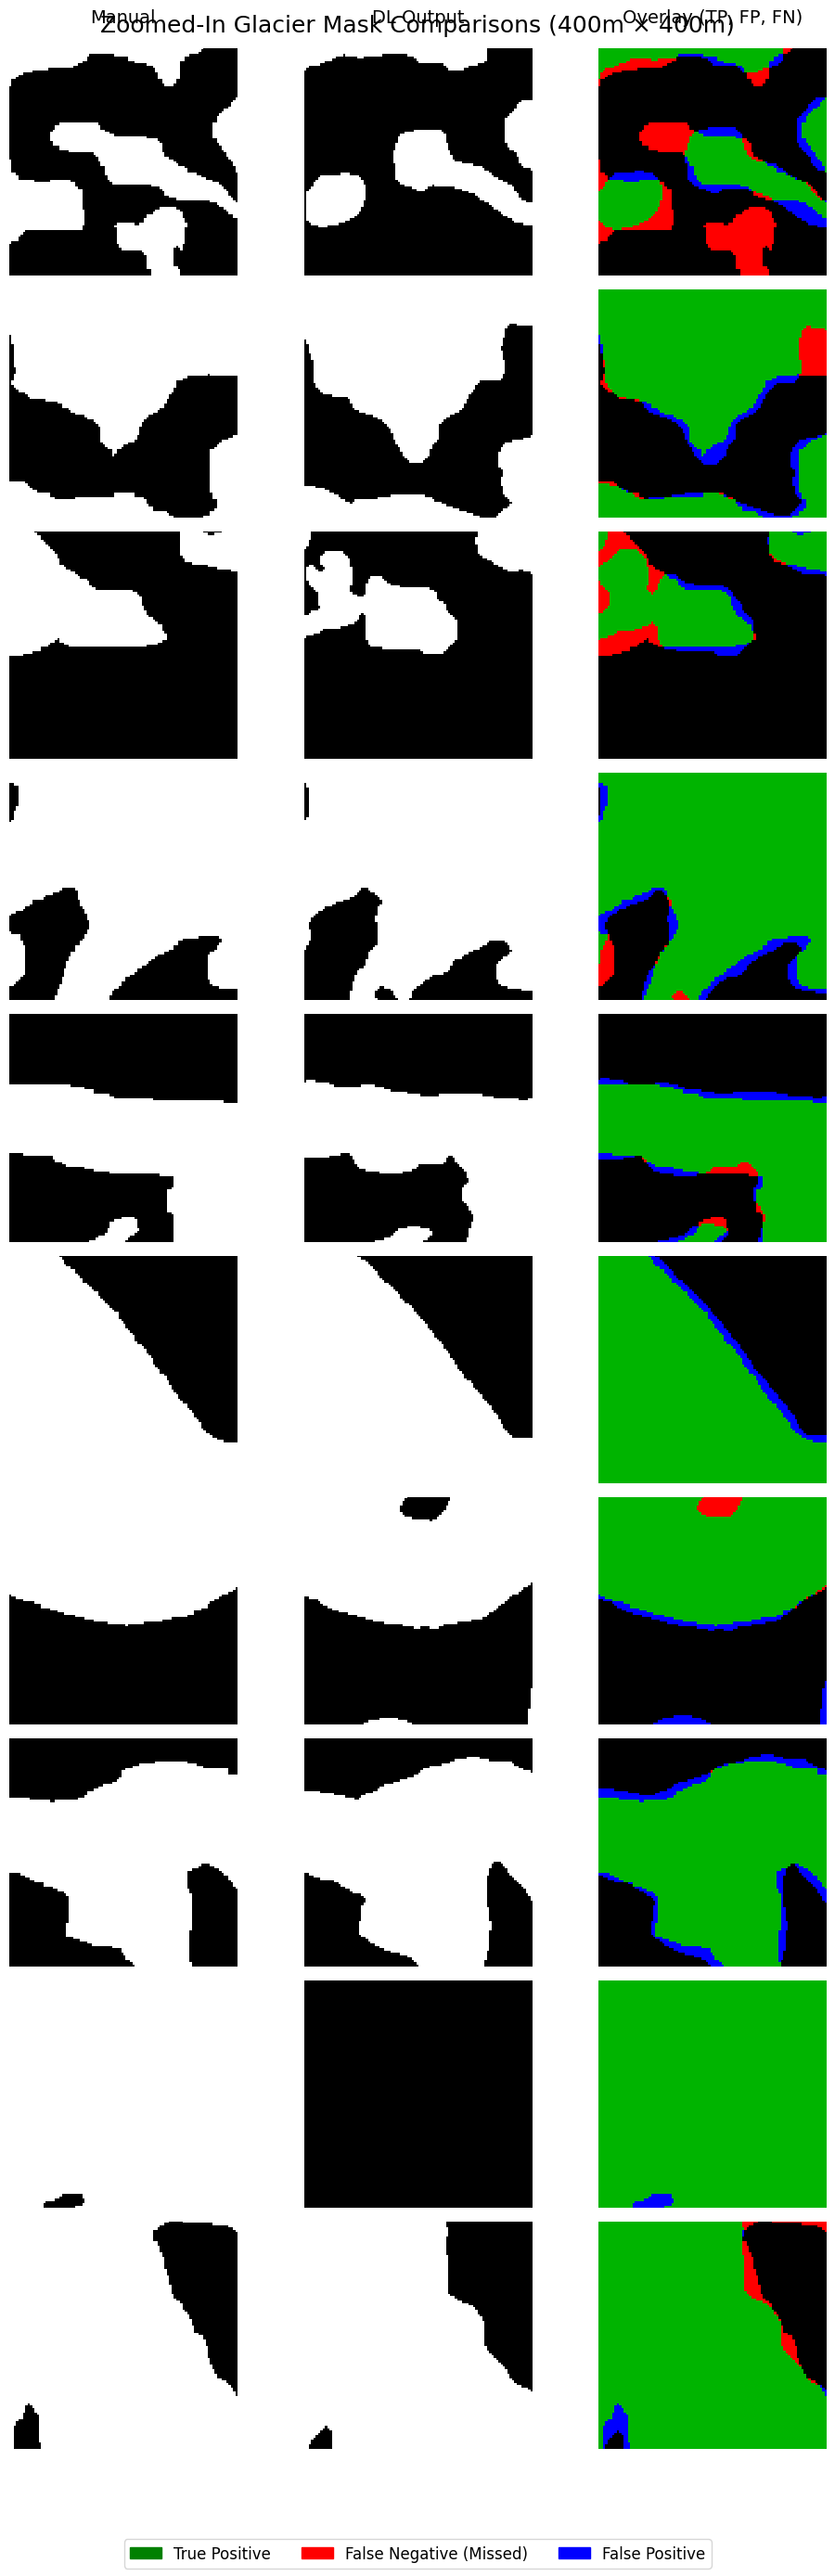

In [15]:
import matplotlib.patches as mpatches

# === Enhanced Academic-Style Zoomed-In Plots ===
np.random.seed(42)
glacier_indices = np.argwhere(manual_mask)
sample_indices = glacier_indices[np.random.choice(glacier_indices.shape[0], 10, replace=False)]

fig, axes = plt.subplots(10, 3, figsize=(10, 30))
column_titles = ["Manual", "DL Output", "Overlay (TP, FP, FN)"]

for col, title in enumerate(column_titles):
    axes[0, col].set_title(title, fontsize=14, pad=20)

for i, (y, x) in enumerate(sample_indices):
    x1 = max(0, x - window_size // 2)
    y1 = max(0, y - window_size // 2)
    x2 = min(glacier_mask.shape[1], x1 + window_size)
    y2 = min(glacier_mask.shape[0], y1 + window_size)

    # === Manual mask ===
    manual_crop = manual_mask[y1:y2, x1:x2]
    axes[i, 0].imshow(manual_crop, cmap='gray', interpolation='none')
    axes[i, 0].set_ylabel(f"Patch {i+1}", fontsize=12, labelpad=10)

    # === DL Output ===
    dl_crop = glacier_mask[y1:y2, x1:x2]
    axes[i, 1].imshow(dl_crop, cmap='gray', interpolation='none')

    # === Overlay ===
    overlay_patch = np.zeros((y2 - y1, x2 - x1, 3), dtype=np.uint8)
    smooth_crop = smooth_mask[y1:y2, x1:x2]

    tp = manual_crop & smooth_crop
    fn = manual_crop & ~smooth_crop
    fp = ~manual_crop & smooth_crop

    overlay_patch[tp] = [0, 180, 0]       # Green (TP)
    overlay_patch[fn] = [255, 0, 0]       # Red (FN)
    overlay_patch[fp] = [0, 0, 255]       # Blue (FP)

    axes[i, 2].imshow(overlay_patch, interpolation='none')

    for ax in axes[i]:
        ax.axis('off')

# Add a single legend
legend_elements = [
    mpatches.Patch(color='green', label='True Positive'),
    mpatches.Patch(color='red', label='False Negative (Missed)'),
    mpatches.Patch(color='blue', label='False Positive'),
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=12)
plt.suptitle("Zoomed-In Glacier Mask Comparisons (400m × 400m)", fontsize=18, y=0.92)
plt.tight_layout(rect=[0, 0.04, 1, 0.94])
plt.show()


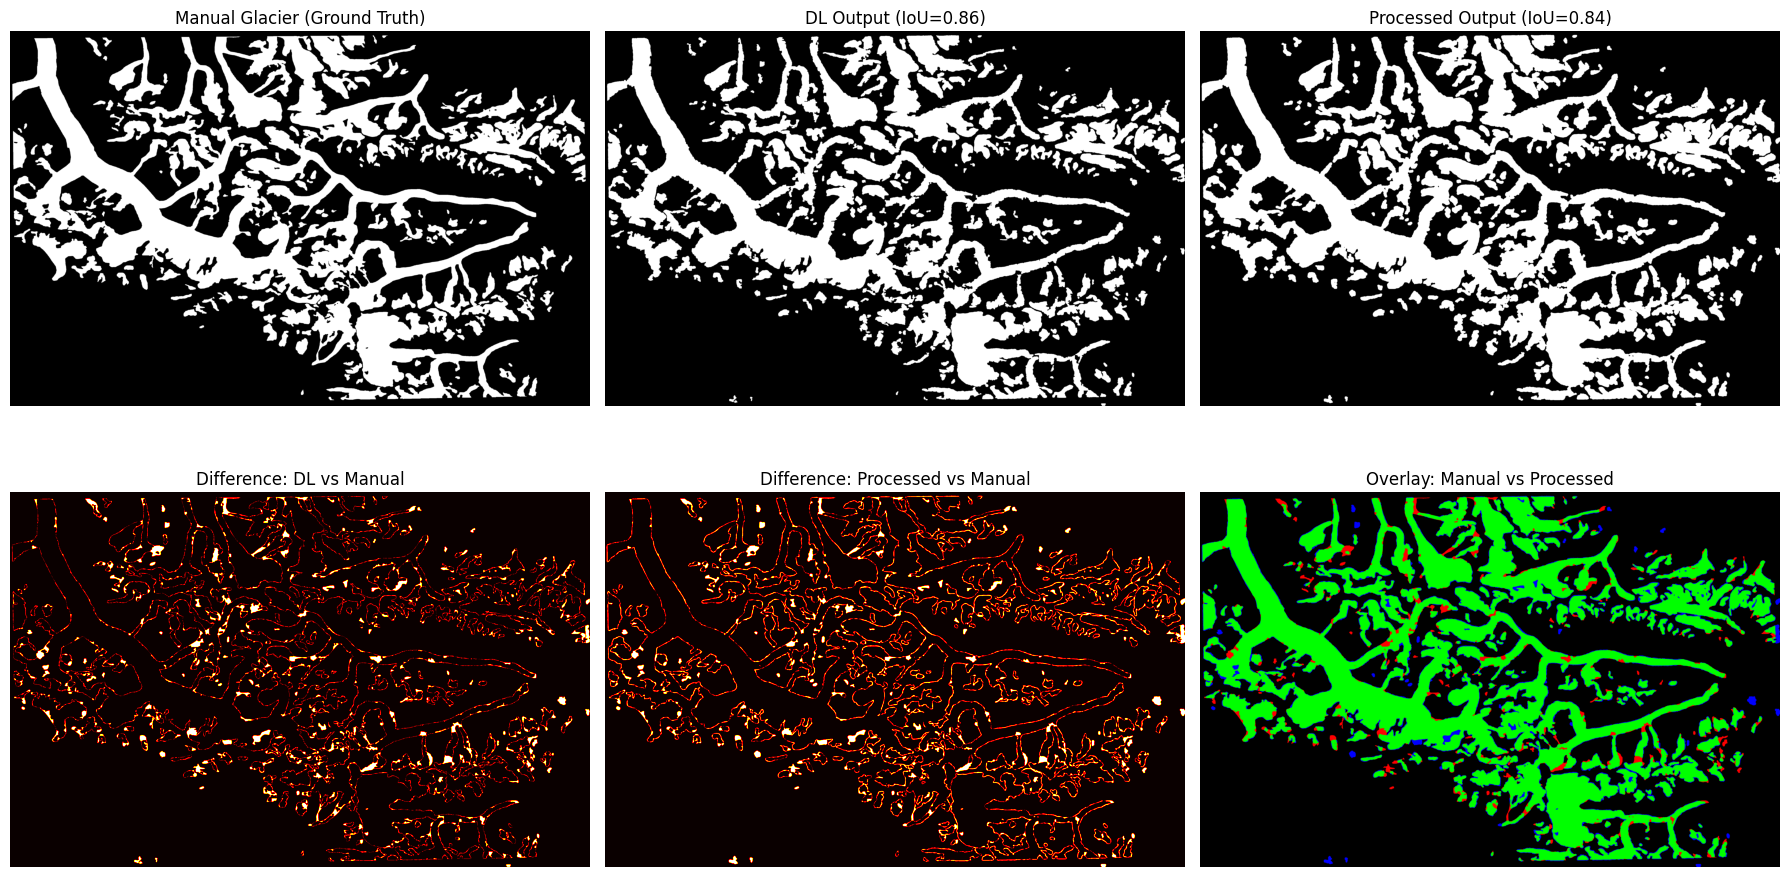

In [17]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_erosion, label, distance_transform_edt
from skimage.morphology import remove_small_objects, closing, disk
from rasterio.warp import reproject, Resampling
from skimage.segmentation import expand_labels

# === Parameters ===
manual_raster = "Z:/objective-1/original_mask/satopanth_mask.tif"
input_raster = "Z:/objective-1/sfs_results/post_processing/saunet_6_satopanth.tif"
output_raster = "Z:/objective-1/sfs_results/post_processing/using_python/sato_saunet_processed_v2.tif"
min_area_km2 = 0.03
merge_distance_m = 30
pixel_resolution = 10

# === Step 1: Load and resample manual mask ===
with rasterio.open(manual_raster) as manual_src:
    manual_mask_orig = manual_src.read(1).astype(np.uint8)
    manual_transform = manual_src.transform
    manual_crs = manual_src.crs

with rasterio.open(input_raster) as src:
    glacier_mask_orig = src.read(1).astype(np.uint8)
    profile = src.profile
    transform = src.transform
    input_shape = glacier_mask_orig.shape
    input_crs = src.crs

# Reproject manual to input raster grid
manual_mask_resampled = np.zeros(input_shape, dtype=np.uint8)
reproject(
    source=manual_mask_orig,
    destination=manual_mask_resampled,
    src_transform=manual_transform,
    src_crs=manual_crs,
    dst_transform=transform,
    dst_crs=input_crs,
    resampling=Resampling.nearest
)

# Convert to binary masks
manual_mask = manual_mask_resampled > 0
input_mask = glacier_mask_orig > 0

# === Step 2: Remove small polygons from both masks ===
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
manual_mask = remove_small_objects(manual_mask, min_size=min_area_pixels)
input_mask = remove_small_objects(input_mask, min_size=min_area_pixels)

# === Step 3: Adaptive merging using label expansion ===
labeled_mask, _ = label(input_mask)
expanded_mask = expand_labels(labeled_mask, distance=(merge_distance_m // pixel_resolution))
reconnected_mask = expanded_mask > 0

# === Step 4: Smoothing ===
smoothed_mask = binary_dilation(reconnected_mask, structure=np.ones((3, 3)))
smoothed_mask = binary_erosion(smoothed_mask, structure=np.ones((3, 3)))
smoothed_mask = closing(smoothed_mask, disk(2))

# === Step 5: Save processed mask ===
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(smoothed_mask.astype(np.uint8), 1)

# === Step 6: Compute IoU ===
def compute_iou(pred, true):
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    return intersection / union if union > 0 else 0.0

iou_dl = compute_iou(input_mask, manual_mask)
iou_processed = compute_iou(smoothed_mask, manual_mask)

# === Step 7: Plot full comparison ===
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs[0, 0].imshow(manual_mask, cmap='gray')
axs[0, 0].set_title("Manual Glacier (Ground Truth)")
axs[0, 1].imshow(input_mask, cmap='gray')
axs[0, 1].set_title(f"DL Output (IoU={iou_dl:.2f})")
axs[0, 2].imshow(smoothed_mask, cmap='gray')
axs[0, 2].set_title(f"Processed Output (IoU={iou_processed:.2f})")

# Differences and overlay
diff_dl = np.logical_xor(manual_mask, input_mask)
diff_processed = np.logical_xor(manual_mask, smoothed_mask)
overlay = np.zeros((*manual_mask.shape, 3), dtype=np.uint8)
overlay[manual_mask & ~smoothed_mask] = [255, 0, 0]     # Missed: Red
overlay[~manual_mask & smoothed_mask] = [0, 0, 255]     # False positive: Blue
overlay[manual_mask & smoothed_mask] = [0, 255, 0]      # Correct: Green

axs[1, 0].imshow(diff_dl, cmap='hot')
axs[1, 0].set_title("Difference: DL vs Manual")
axs[1, 1].imshow(diff_processed, cmap='hot')
axs[1, 1].set_title("Difference: Processed vs Manual")
axs[1, 2].imshow(overlay)
axs[1, 2].set_title("Overlay: Manual vs Processed")

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [18]:
def compute_metrics(pred, true):
    TP = np.logical_and(pred, true).sum()
    FP = np.logical_and(pred, np.logical_not(true)).sum()
    FN = np.logical_and(np.logical_not(pred), true).sum()

    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall = TP / (TP + FN) if (TP + FN) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    iou = TP / (TP + FP + FN) if (TP + FP + FN) else 0.0

    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'IoU': iou
    }

metrics_dl = compute_metrics(input_mask, manual_mask)
metrics_processed = compute_metrics(smoothed_mask, manual_mask)

print("=== DL Mask Metrics ===")
for k, v in metrics_dl.items():
    print(f"{k}: {v:.4f}")
print("\n=== Processed Mask Metrics ===")
for k, v in metrics_processed.items():
    print(f"{k}: {v:.4f}")


=== DL Mask Metrics ===
Precision: 0.9499
Recall: 0.9030
F1 Score: 0.9258
IoU: 0.8619

=== Processed Mask Metrics ===
Precision: 0.8819
Recall: 0.9432
F1 Score: 0.9115
IoU: 0.8374


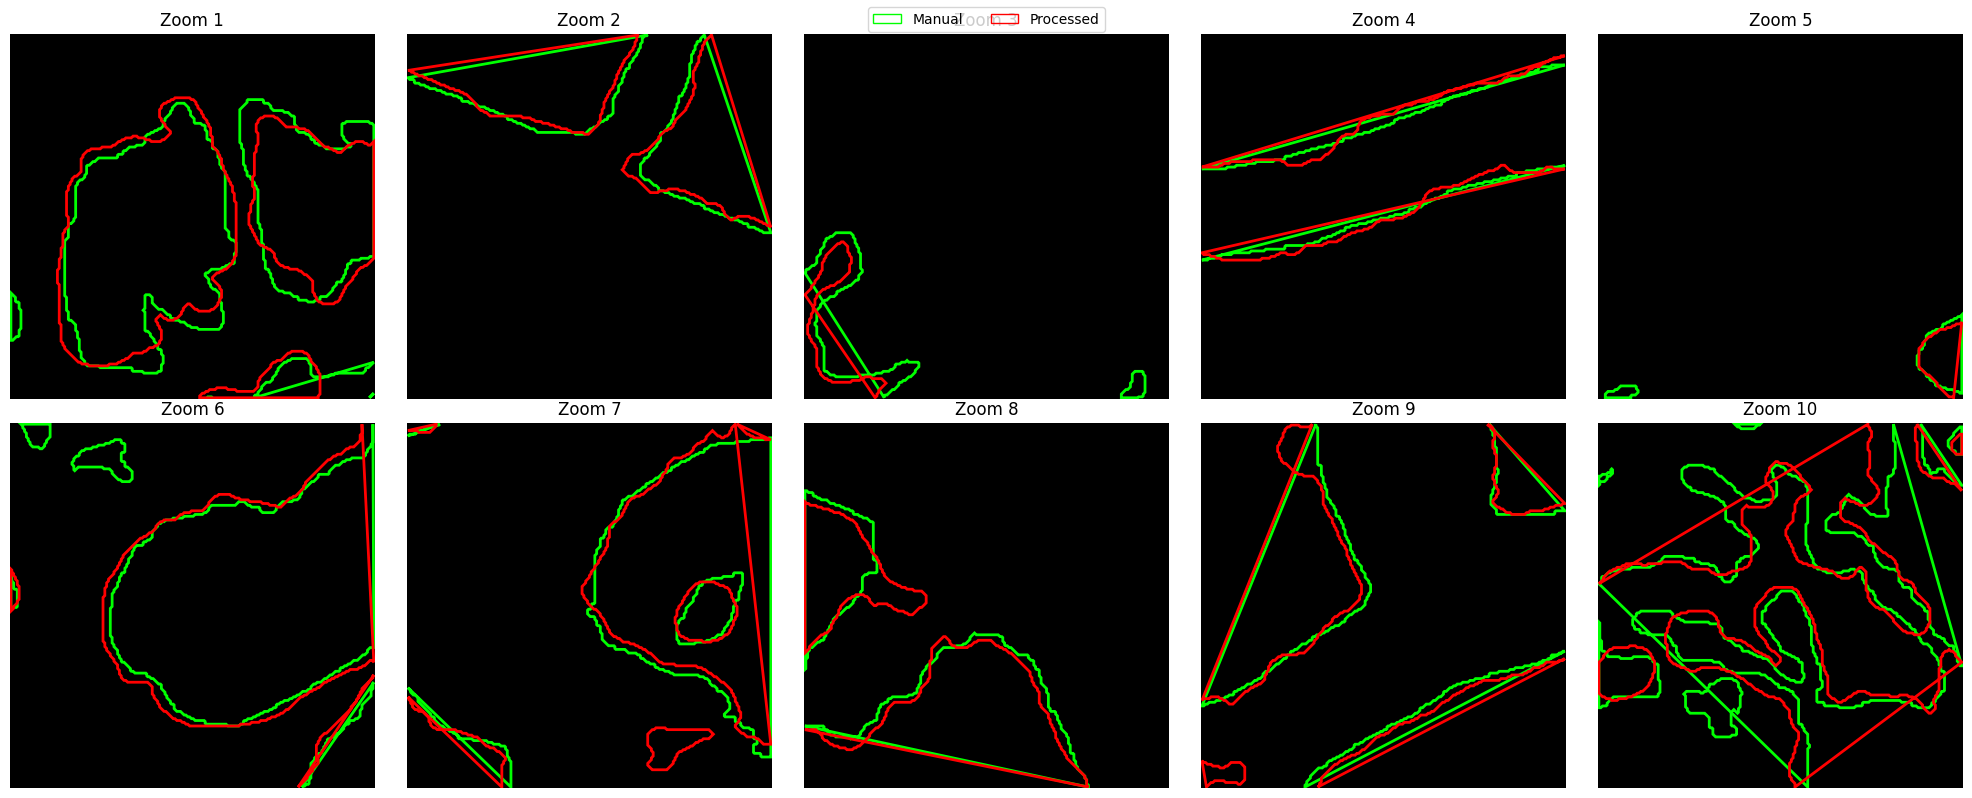

In [23]:
import random
from skimage.measure import find_contours
from matplotlib.patches import Polygon

def plot_zoomed_regions(mask1, mask2, transform, num_samples=10, region_km=1):
    height, width = mask1.shape
    region_px = int(region_km * 2000 / pixel_resolution)

    valid_coords = np.argwhere(mask1 | mask2)
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    axs = axs.flatten()

    for i in range(num_samples):
        yx = valid_coords[random.randint(0, len(valid_coords) - 1)]
        y, x = yx

        x_start = max(x - region_px // 2, 0)
        x_end = min(x_start + region_px, width)
        y_start = max(y - region_px // 2, 0)
        y_end = min(y_start + region_px, height)

        sub_manual = mask1[y_start:y_end, x_start:x_end]
        sub_pred = mask2[y_start:y_end, x_start:x_end]

        ax = axs[i]
        ax.imshow(np.zeros_like(sub_manual), cmap='gray')

        # Overlay outlines
        for mask, color, label in zip([sub_manual, sub_pred], ['lime', 'red'], ['Manual', 'Processed']):
            contours = find_contours(mask.astype(float), 0.5)
            for contour in contours:
                poly = Polygon(contour[:, ::-1], edgecolor=color, facecolor='none', linewidth=2, label=label)
                ax.add_patch(poly)

        ax.set_title(f"Zoom {i+1}")
        ax.axis('off')

    handles = [Polygon([[0, 0]], edgecolor=c, facecolor='none', label=l) for c, l in zip(['lime', 'red'], ['Manual', 'Processed'])]
    fig.legend(handles=handles, loc='upper center', ncol=2)
    plt.tight_layout()
    plt.show()

plot_zoomed_regions(manual_mask, smoothed_mask, transform)



=== IoU with Buffered Ground Truth ===
+20m: IoU = 0.8390
+10m: IoU = 0.8594
0m: IoU = 0.8619
-10m: IoU = 0.8497
-20m: IoU = 0.8279

Best match: 0m with IoU = 0.8619


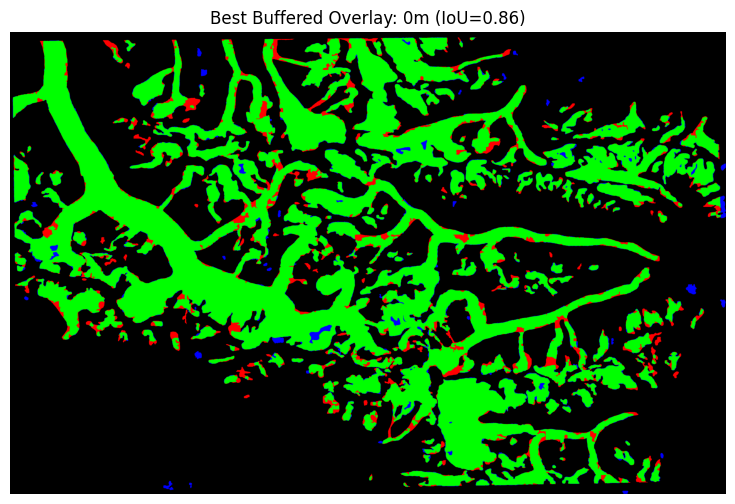

In [26]:
from collections import OrderedDict

# Create buffered masks from manual reference
buffer_distances = OrderedDict({
    "+20m": binary_dilation(manual_mask, structure=np.ones((5, 5))),
    "+10m": binary_dilation(manual_mask, structure=np.ones((3, 3))),
    "0m": manual_mask,
    "-10m": binary_erosion(manual_mask, structure=np.ones((3, 3))),
    "-20m": binary_erosion(manual_mask, structure=np.ones((5, 5))),
})

# Compute IoUs with input (DL) mask for each buffered version
iou_results = {}
for label, buffered_mask in buffer_distances.items():
    iou = compute_iou(input_mask, buffered_mask)
    iou_results[label] = iou

# Find best IoU and corresponding buffer
best_buffer = max(iou_results, key=iou_results.get)
best_iou = iou_results[best_buffer]
best_mask = buffer_distances[best_buffer]

print("\n=== IoU with Buffered Ground Truth ===")
for k, v in iou_results.items():
    print(f"{k}: IoU = {v:.4f}")
print(f"\nBest match: {best_buffer} with IoU = {best_iou:.4f}")

# Visualize best overlay
plt.figure(figsize=(10, 6))
overlay_best = np.zeros((*manual_mask.shape, 3), dtype=np.uint8)
overlay_best[best_mask & ~input_mask] = [255, 0, 0]     # Missed
overlay_best[~best_mask & input_mask] = [0, 0, 255]     # False Positive
overlay_best[best_mask & input_mask] = [0, 255, 0]      # True Positive

plt.imshow(overlay_best)
plt.title(f"Best Buffered Overlay: {best_buffer} (IoU={best_iou:.2f})")
plt.axis('off')
plt.show()



In [27]:
from collections import OrderedDict

# Create buffered versions of the input (predicted) mask
buffer_distances = OrderedDict({
    "+20m": binary_dilation(input_mask, structure=np.ones((5, 5))),
    "+10m": binary_dilation(input_mask, structure=np.ones((3, 3))),
    "0m": input_mask,
    "-10m": binary_erosion(input_mask, structure=np.ones((3, 3))),
    "-20m": binary_erosion(input_mask, structure=np.ones((5, 5))),
})

# Compute IoUs with manual (ground truth) mask
iou_results = {}
for label, buffered_mask in buffer_distances.items():
    iou = compute_iou(buffered_mask, manual_mask)
    iou_results[label] = iou

# Find the best IoU
best_buffer = max(iou_results, key=iou_results.get)
best_iou = iou_results[best_buffer]
best_mask = buffer_distances[best_buffer]

print("\n=== IoU of Buffered Input Masks vs Manual ===")
for k, v in iou_results.items():
    print(f"{k}: IoU = {v:.4f}")
print(f"\nBest Buffered Input: {best_buffer} with IoU = {best_iou:.4f}")



=== IoU of Buffered Input Masks vs Manual ===
+20m: IoU = 0.8424
+10m: IoU = 0.8565
0m: IoU = 0.8619
-10m: IoU = 0.8527
-20m: IoU = 0.8242

Best Buffered Input: 0m with IoU = 0.8619


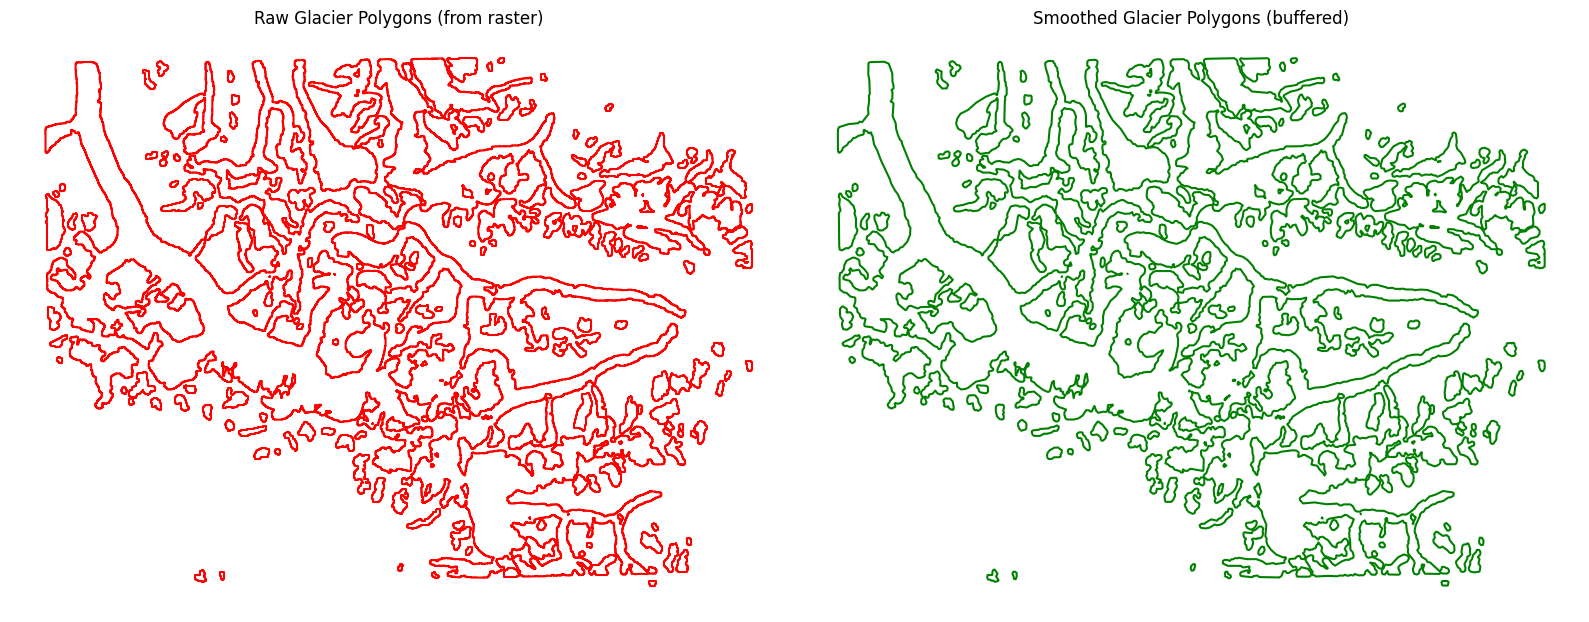

In [31]:
import rasterio
import numpy as np
from skimage.morphology import remove_small_objects, closing, disk
from scipy.ndimage import binary_dilation, binary_erosion, label
from skimage.segmentation import expand_labels
from rasterio.features import shapes
from shapely.geometry import shape, Polygon, MultiPolygon
from shapely.ops import unary_union
import geopandas as gpd
import matplotlib.pyplot as plt

# === Parameters ===
input_raster = "Z:/objective-1/sfs_results/post_processing/using_python/sato_saunet_processed_v2.tif"
shapefile_raw = "Z:/objective-1/sfs_results/post_processing/using_python/sf/sato_saunet_raw.shp"
shapefile_smooth = "Z:/objective-1/sfs_results/post_processing/using_python/sf/sato_saunet_smooth.shp"
min_area_km2 = 0.03
pixel_resolution = 10  # meters
merge_distance_m = 10

# === Read Raster ===
with rasterio.open(input_raster) as src:
    glacier_mask_orig = src.read(1).astype(np.uint8)
    transform = src.transform
    crs = src.crs

# === Step 1: Binary mask and noise removal ===
binary_mask = glacier_mask_orig > 0
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
cleaned_mask = remove_small_objects(binary_mask, min_size=min_area_pixels)

# === Step 2: Reconnect close fragments ===
labeled_mask, _ = label(cleaned_mask)
expanded_mask = expand_labels(labeled_mask, distance=(merge_distance_m // pixel_resolution))
reconnected_mask = expanded_mask > 0

# === Step 3: Morphological smoothing ===
smoothed = binary_dilation(reconnected_mask, structure=np.ones((3, 3)))
smoothed = binary_erosion(smoothed, structure=np.ones((3, 3)))
smoothed = closing(smoothed, disk(2))

# === Step 4: Raster to raw polygons ===
raw_shapes = shapes(smoothed.astype(np.uint8), mask=smoothed, transform=transform)
geoms = []
for geom, val in raw_shapes:
    if val == 1:
        shapely_geom = shape(geom)
        if isinstance(shapely_geom, Polygon):
            geoms.append(shapely_geom)
        elif isinstance(shapely_geom, MultiPolygon):
            geoms.extend(shapely_geom.geoms)

# === Step 5: Raw shapefile ===
gdf_raw = gpd.GeoDataFrame(geometry=geoms, crs=crs)
gdf_raw.to_file(shapefile_raw)

# === Step 6: Smooth the geometry using buffer-simplify-buffer ===
smooth_geoms = [poly.buffer(0.0001).buffer(-0.0001).simplify(tolerance=0.0002, preserve_topology=True) for poly in geoms]
gdf_smooth = gpd.GeoDataFrame(geometry=smooth_geoms, crs=crs)
gdf_smooth.to_file(shapefile_smooth)

# === Step 7: Plot before and after ===
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_raw.boundary.plot(ax=axs[0], color='red')
axs[0].set_title("Raw Glacier Polygons (from raster)")
axs[0].axis('off')

gdf_smooth.boundary.plot(ax=axs[1], color='green')
axs[1].set_title("Smoothed Glacier Polygons (buffered)")
axs[1].axis('off')

plt.tight_layout()
plt.show()




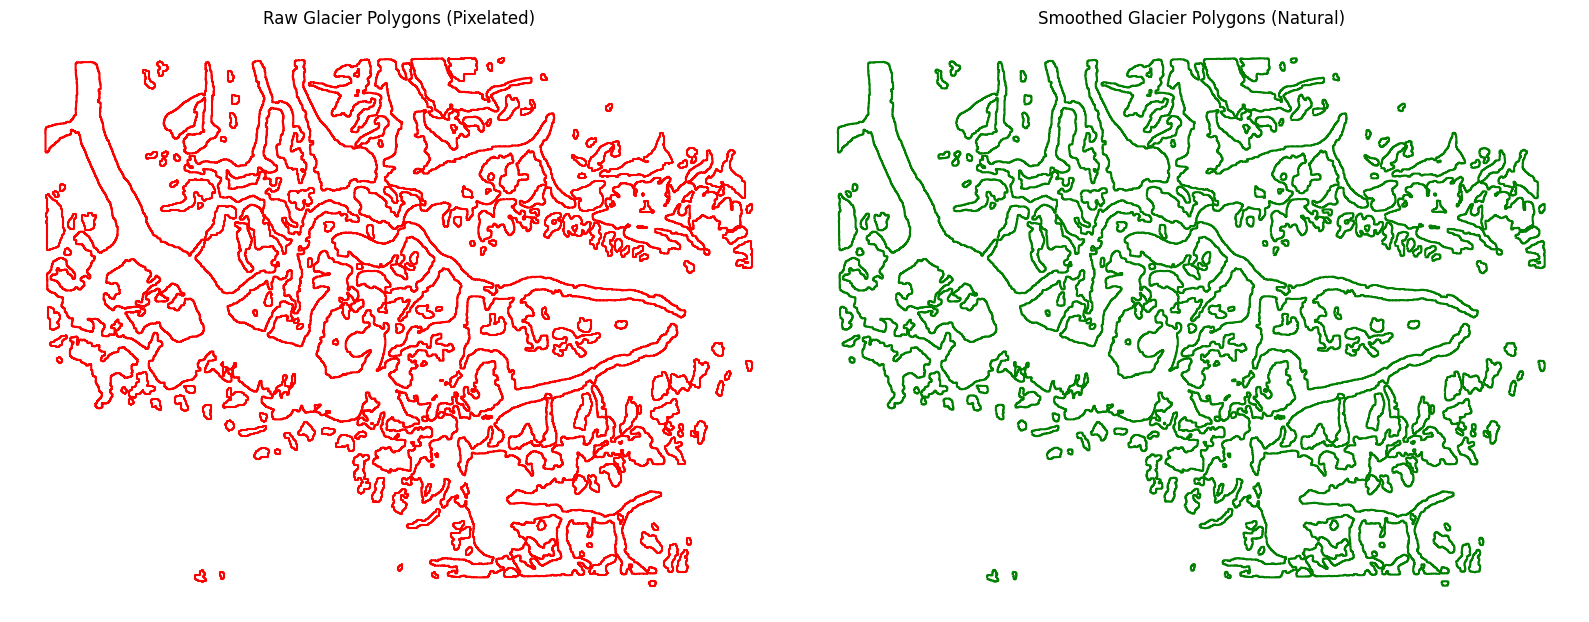

In [43]:
import rasterio
import numpy as np
from skimage.morphology import remove_small_objects, closing, disk
from scipy.ndimage import binary_dilation, binary_erosion, label
from skimage.segmentation import expand_labels
from rasterio.features import shapes
from shapely.geometry import shape, Polygon, MultiPolygon
from shapely.ops import unary_union
import geopandas as gpd
import matplotlib.pyplot as plt

# === Parameters ===
input_raster = "Z:/objective-1/sfs_results/post_processing/using_python/sato_saunet_processed_v2.tif"
shapefile_raw = "Z:/objective-1/sfs_results/post_processing/using_python/sf/sato_saunet_raw.shp"
shapefile_smooth = "Z:/objective-1/sfs_results/post_processing/using_python/sf/sato_saunet_smooth.shp"
min_area_km2 = 0.03
pixel_resolution = 10  # meters
merge_distance_m = 0  # Connect small fragments

# === Read Raster ===
with rasterio.open(input_raster) as src:
    glacier_mask_orig = src.read(1).astype(np.uint8)
    transform = src.transform
    crs = src.crs

# === Step 1: Binary mask and clean small blobs ===
binary_mask = glacier_mask_orig > 0
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
cleaned_mask = remove_small_objects(binary_mask, min_size=min_area_pixels)

# === Step 2: Expand to reconnect nearby fragments ===
labeled_mask, _ = label(cleaned_mask)
expanded_mask = expand_labels(labeled_mask, distance=(merge_distance_m // pixel_resolution))
reconnected_mask = expanded_mask > 0

# === Step 3: Morphological smoothing ===
smoothed = binary_dilation(reconnected_mask, structure=np.ones((5, 5)))  # Stronger smoothing
smoothed = binary_erosion(smoothed, structure=np.ones((5, 5)))
smoothed = closing(smoothed, disk(3))  # Round edges

# === Step 4: Raster to vector shapes ===
raw_shapes = shapes(smoothed.astype(np.uint8), mask=smoothed, transform=transform)
geoms = []
for geom, val in raw_shapes:
    if val == 1:
        shp = shape(geom)
        if isinstance(shp, Polygon):
            geoms.append(shp)
        elif isinstance(shp, MultiPolygon):
            geoms.extend(shp.geoms)

gdf_raw = gpd.GeoDataFrame(geometry=geoms, crs=crs)
gdf_raw.to_file(shapefile_raw)

# === Step 5: Project to metric CRS (UTM or EPSG:32644 as example) ===
utm_crs = gdf_raw.estimate_utm_crs()
gdf_proj = gdf_raw.to_crs(utm_crs)

# === Step 6: Buffer-simplify-buffer for smoothing (in meters) ===
buffer_size = 5  # meters
tolerance = 1    # meters
smooth_geoms = [
    geom.buffer(buffer_size).buffer(-buffer_size).simplify(tolerance=tolerance, preserve_topology=True)
    for geom in gdf_proj.geometry
]

gdf_smooth = gpd.GeoDataFrame(geometry=smooth_geoms, crs=utm_crs)

# === Optional: Remove invalid or empty geometries ===
gdf_smooth = gdf_smooth[gdf_smooth.is_valid & ~gdf_smooth.is_empty]

# === Save smoothed shapefile (reprojected back to original CRS) ===
gdf_smooth.to_crs(crs).to_file(shapefile_smooth)

# === Plot raw vs smoothed ===
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_raw.boundary.plot(ax=axs[0], color='red')
axs[0].set_title("Raw Glacier Polygons (Pixelated)")
axs[0].axis('off')

gdf_smooth.to_crs(crs).boundary.plot(ax=axs[1], color='green')
axs[1].set_title("Smoothed Glacier Polygons (Natural)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [44]:
from pyproj import CRS

# Get a representative longitude and latitude from glacier geometries
centroid = gdf_raw.geometry[0].centroid
lon, lat = centroid.x, centroid.y

# Determine UTM zone manually
zone_number = int((lon + 180) / 6) + 1
is_northern = lat >= 0
utm_epsg = 32600 + zone_number if is_northern else 32700 + zone_number
utm_crs = CRS.from_epsg(utm_epsg)

# Reproject both raw and smooth GeoDataFrames
gdf_raw_utm = gdf_raw.to_crs(utm_crs)
gdf_smooth_utm = gdf_smooth.to_crs(utm_crs)


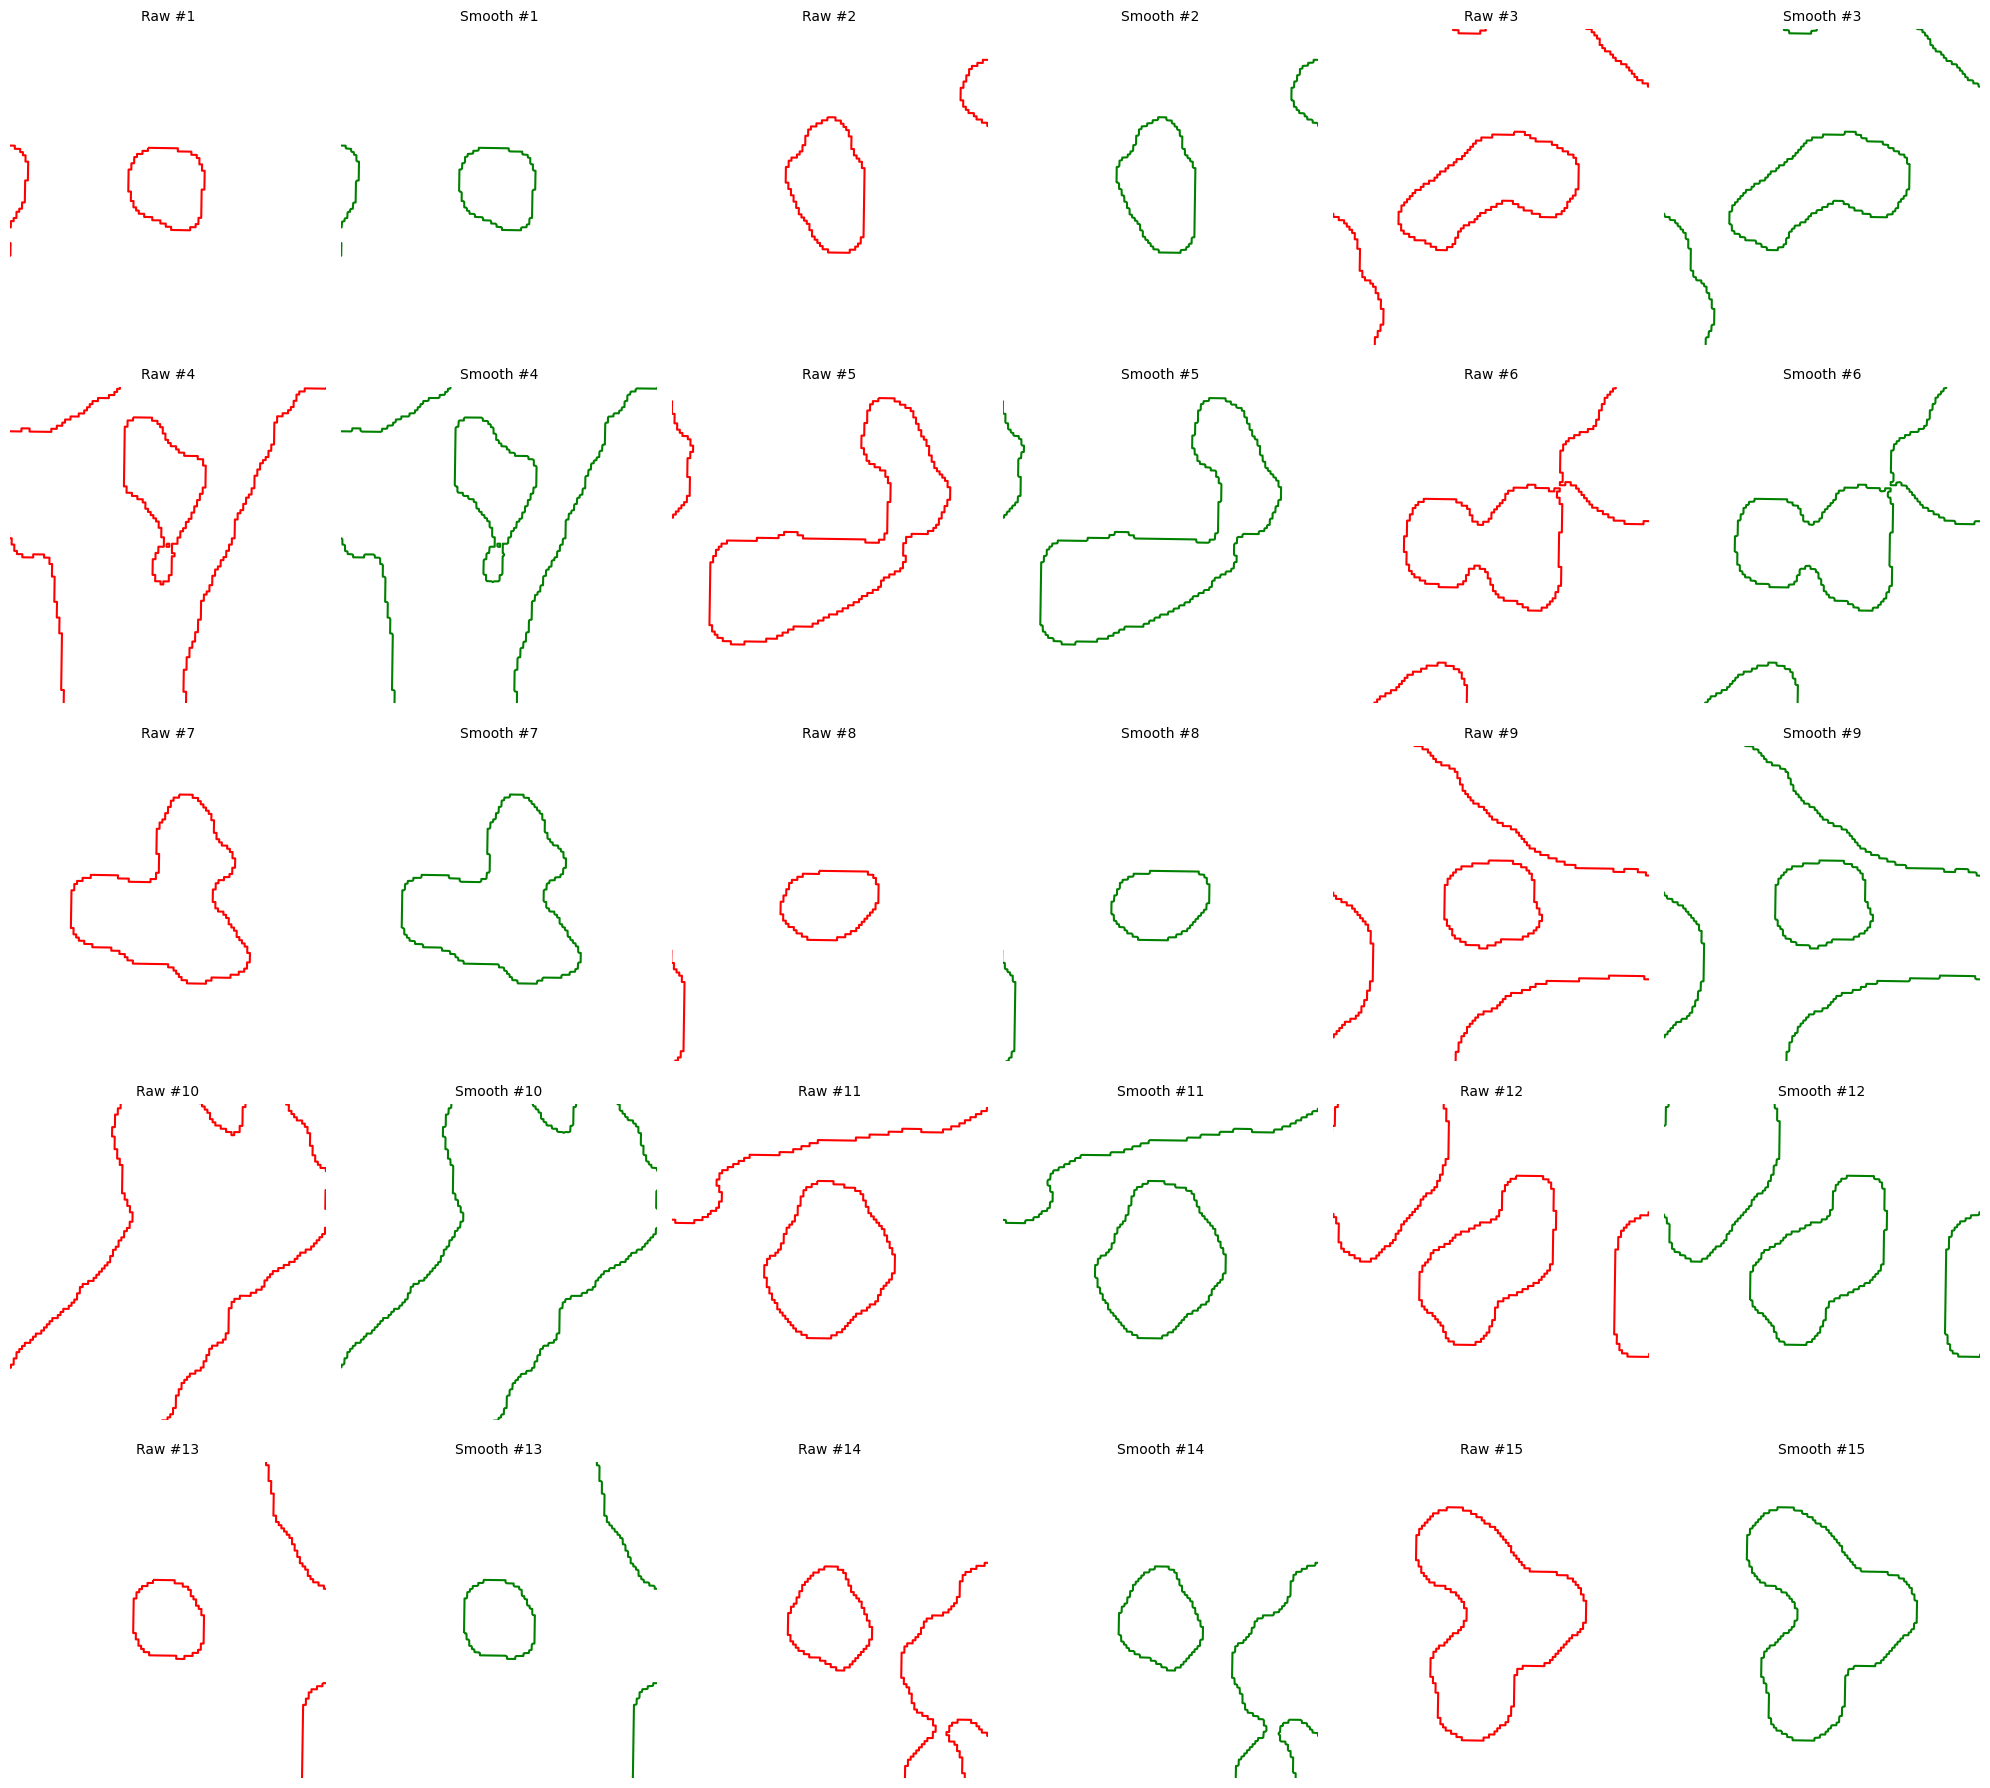

In [45]:
import random
from shapely.geometry import box

# Set zoom window size
zoom_m = 1000
half_zoom = zoom_m / 2

# Confirm CRS is projected
crs = gdf_raw_utm.crs
assert crs.is_projected, "CRS must be projected (meters)."

# Get valid glacier centroids
valid_centroids = [geom.centroid for geom in gdf_raw_utm.geometry if geom.is_valid and not geom.is_empty]
sample_centroids = random.sample(valid_centroids, min(15, len(valid_centroids)))

# Create plot grid (15 pairs = 30 plots)
fig, axs = plt.subplots(5, 6, figsize=(20, 18))
axs = axs.flatten()

for i, centroid in enumerate(sample_centroids):
    xmin, ymin = centroid.x - half_zoom, centroid.y - half_zoom
    xmax, ymax = centroid.x + half_zoom, centroid.y + half_zoom
    zoom_box = box(xmin, ymin, xmax, ymax)

    raw_zoom = gdf_raw_utm[gdf_raw_utm.intersects(zoom_box)]
    smooth_zoom = gdf_smooth_utm[gdf_smooth_utm.intersects(zoom_box)]

    axs[2 * i].set_title(f"Raw #{i+1}", fontsize=10)
    axs[2 * i].axis('off')
    raw_zoom.boundary.plot(ax=axs[2 * i], color='red')
    axs[2 * i].set_xlim(xmin, xmax)
    axs[2 * i].set_ylim(ymin, ymax)

    axs[2 * i + 1].set_title(f"Smooth #{i+1}", fontsize=10)
    axs[2 * i + 1].axis('off')
    smooth_zoom.boundary.plot(ax=axs[2 * i + 1], color='green')
    axs[2 * i + 1].set_xlim(xmin, xmax)
    axs[2 * i + 1].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


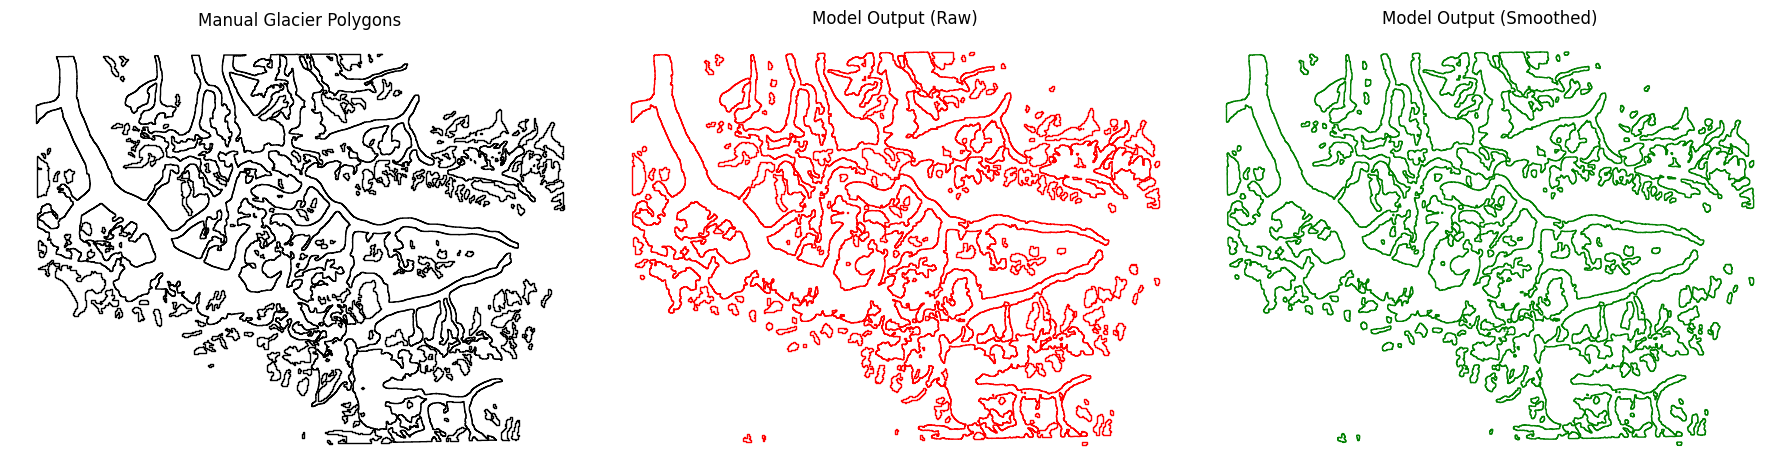

In [51]:
import rasterio
import numpy as np
from skimage.morphology import remove_small_objects, closing, disk
from scipy.ndimage import binary_dilation, binary_erosion, label
from rasterio.features import shapes
from shapely.geometry import shape, Polygon, MultiPolygon
from shapely.ops import unary_union
import geopandas as gpd
import matplotlib.pyplot as plt

# === File Paths ===
manual_raster = "Z:/objective-1/original_mask/satopanth_mask.tif"
input_raster = "Z:/objective-1/sfs_results/post_processing/using_python/sato_saunet_processed_v2.tif"

shp_manual = "Z:/objective-1/sfs_results/post_processing/using_python/sf/satopanth_manual.shp"
shp_model_raw = "Z:/objective-1/sfs_results/post_processing/using_python/sf/sato_saunet_raw.shp"
shp_model_smooth = "Z:/objective-1/sfs_results/post_processing/using_python/sf/sato_saunet_smooth.shp"

min_area_km2 = 0.03
pixel_resolution = 10  # meters
merge_distance_m = 10

# === 1. Load Manual Raster ===
with rasterio.open(manual_raster) as src:
    manual_mask = src.read(1).astype(np.uint8)
    manual_transform = src.transform
    manual_crs = src.crs

manual_binary = manual_mask > 0
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
manual_cleaned = remove_small_objects(manual_binary, min_size=min_area_pixels)

# Extract polygons
manual_shapes = shapes(manual_cleaned.astype(np.uint8), mask=manual_cleaned, transform=manual_transform)
manual_geoms = []
for geom, val in manual_shapes:
    if val == 1:
        shp_geom = shape(geom)
        if isinstance(shp_geom, Polygon):
            manual_geoms.append(shp_geom)
        elif isinstance(shp_geom, MultiPolygon):
            manual_geoms.extend(shp_geom.geoms)

gdf_manual = gpd.GeoDataFrame(geometry=manual_geoms, crs=manual_crs)
gdf_manual.to_file(shp_manual)

# === 2. Load Input Raster and Process ===
with rasterio.open(input_raster) as src:
    glacier_mask = src.read(1).astype(np.uint8)
    transform = src.transform
    crs = src.crs

binary_mask = glacier_mask > 0
cleaned = remove_small_objects(binary_mask, min_size=min_area_pixels)

labeled_mask, _ = label(cleaned)
expanded = labeled_mask > 0  # Or use expand_labels if better
smoothed = binary_dilation(expanded, structure=np.ones((3, 3)))
smoothed = binary_erosion(smoothed, structure=np.ones((3, 3)))
smoothed = closing(smoothed, disk(2))

model_shapes = shapes(smoothed.astype(np.uint8), mask=smoothed, transform=transform)
model_geoms = []
for geom, val in model_shapes:
    if val == 1:
        shp_geom = shape(geom)
        if isinstance(shp_geom, Polygon):
            model_geoms.append(shp_geom)
        elif isinstance(shp_geom, MultiPolygon):
            model_geoms.extend(shp_geom.geoms)

gdf_model_raw = gpd.GeoDataFrame(geometry=model_geoms, crs=crs)
gdf_model_raw.to_file(shp_model_raw)

# === 3. Smooth model polygons ===
model_smooth_geoms = [poly.buffer(0.00005).buffer(-0.00005).simplify(0.00002, preserve_topology=True) for poly in model_geoms]
gdf_model_smooth = gpd.GeoDataFrame(geometry=model_smooth_geoms, crs=crs)
gdf_model_smooth.to_file(shp_model_smooth)

# === 4. Plot Comparison ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

gdf_manual.boundary.plot(ax=axs[0], color='black', linewidth=1)
axs[0].set_title("Manual Glacier Polygons")
axs[0].axis('off')

gdf_model_raw.boundary.plot(ax=axs[1], color='red', linewidth=1)
axs[1].set_title("Model Output (Raw)")
axs[1].axis('off')

gdf_model_smooth.boundary.plot(ax=axs[2], color='green', linewidth=1)
axs[2].set_title("Model Output (Smoothed)")
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [47]:
from pyproj import CRS

# Get a representative longitude and latitude from glacier geometries
centroid = gdf_raw.geometry[0].centroid
lon, lat = centroid.x, centroid.y

# Determine UTM zone manually
zone_number = int((lon + 180) / 6) + 1
is_northern = lat >= 0
utm_epsg = 32600 + zone_number if is_northern else 32700 + zone_number
utm_crs = CRS.from_epsg(utm_epsg)

# Reproject both raw and smooth GeoDataFrames
gdf_raw_utm = gdf_raw.to_crs(utm_crs)
gdf_smooth_utm = gdf_smooth.to_crs(utm_crs)

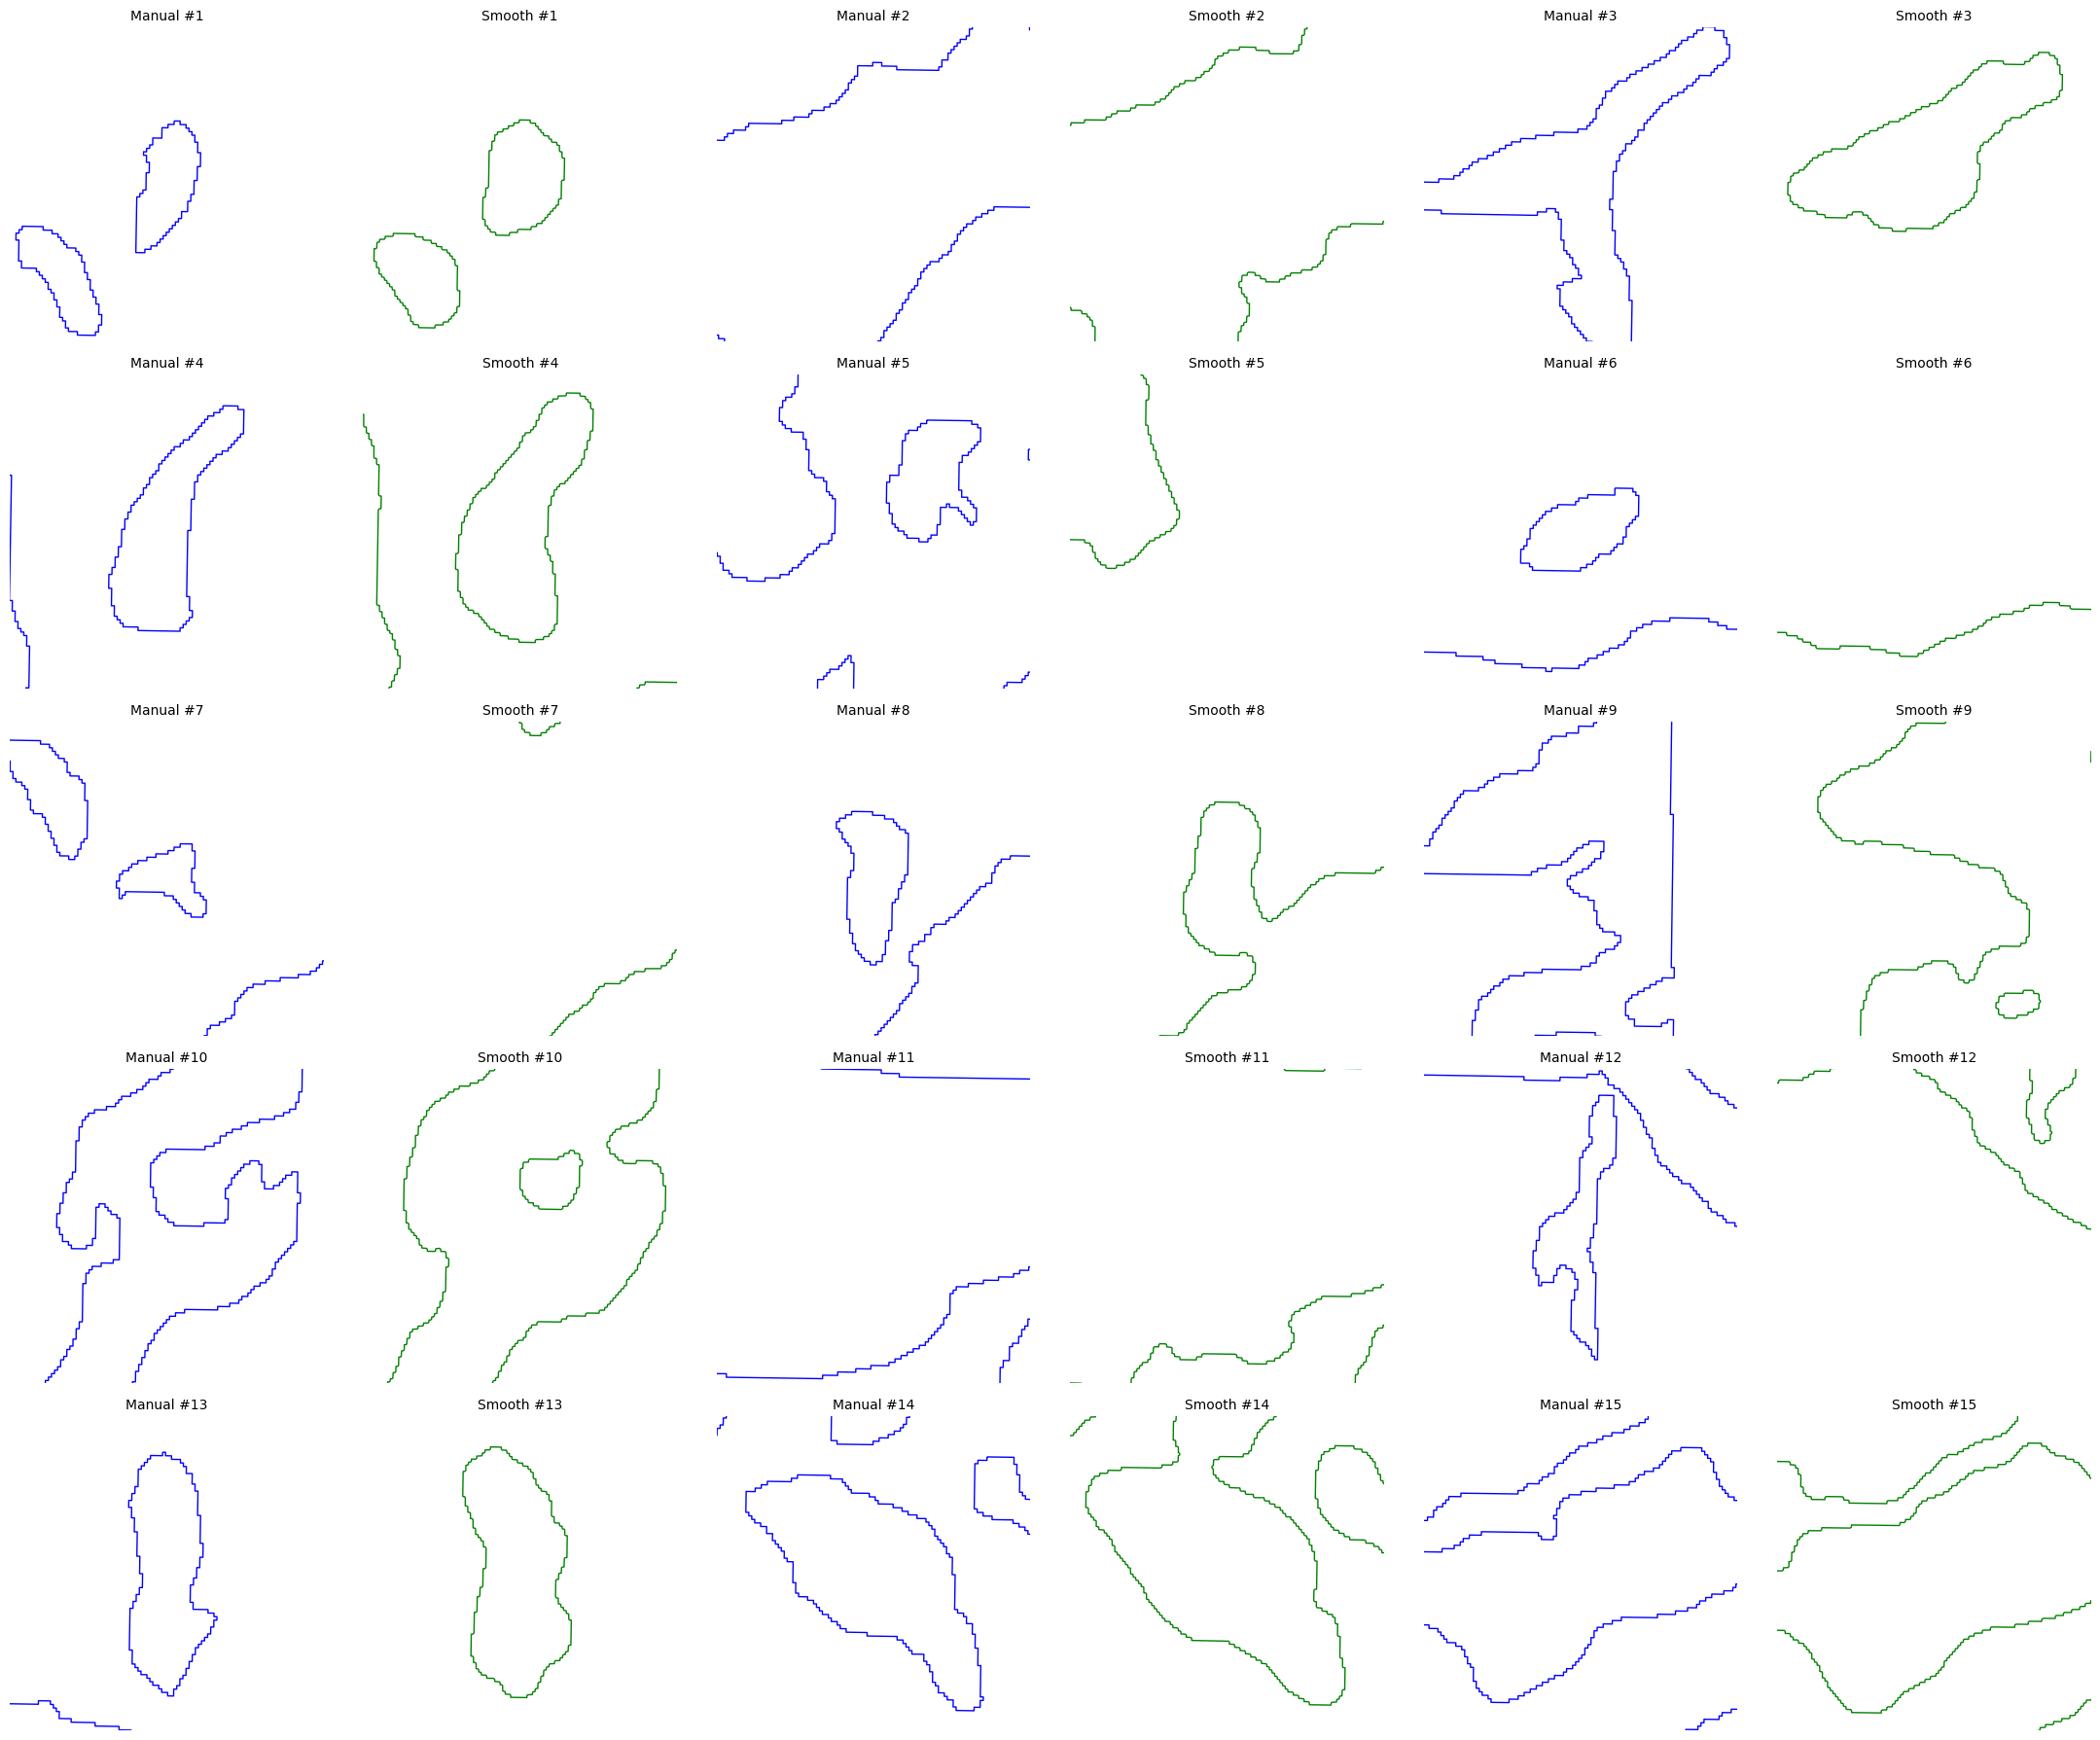

In [52]:
import random
from shapely.geometry import box
import matplotlib.pyplot as plt

# === Reproject to UTM ===
gdf_manual_utm = gdf_manual.to_crs(epsg=32644)       # Replace with correct EPSG if known
gdf_smooth_utm = gdf_smooth.to_crs(gdf_manual_utm.crs)
crs = gdf_manual_utm.crs
assert crs.is_projected, "CRS must be projected (meters)."

# === Define zoom window ===
zoom_m = 1000
half_zoom = zoom_m / 2

# === Get valid centroids from manual shapefile ===
valid_centroids = [geom.centroid for geom in gdf_manual_utm.geometry if geom.is_valid and not geom.is_empty]
sample_centroids = random.sample(valid_centroids, min(15, len(valid_centroids)))

# === Create plot grid (15 pairs = 30 plots) ===
fig, axs = plt.subplots(5, 6, figsize=(22, 18))
axs = axs.flatten()

for i, centroid in enumerate(sample_centroids):
    xmin, ymin = centroid.x - half_zoom, centroid.y - half_zoom
    xmax, ymax = centroid.x + half_zoom, centroid.y + half_zoom
    zoom_box = box(xmin, ymin, xmax, ymax)

    manual_zoom = gdf_manual_utm[gdf_manual_utm.intersects(zoom_box)]
    smooth_zoom = gdf_smooth_utm[gdf_smooth_utm.intersects(zoom_box)]

    # === Manual (left column) ===
    axs[2 * i].set_title(f"Manual #{i+1}", fontsize=10)
    axs[2 * i].axis('off')
    manual_zoom.boundary.plot(ax=axs[2 * i], color='blue', linewidth=1)
    axs[2 * i].set_xlim(xmin, xmax)
    axs[2 * i].set_ylim(ymin, ymax)

    # === Smooth Output (right column) ===
    axs[2 * i + 1].set_title(f"Smooth #{i+1}", fontsize=10)
    axs[2 * i + 1].axis('off')
    smooth_zoom.boundary.plot(ax=axs[2 * i + 1], color='green', linewidth=1)
    axs[2 * i + 1].set_xlim(xmin, xmax)
    axs[2 * i + 1].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [7]:
import rasterio
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion, label, distance_transform_edt
from skimage.morphology import remove_small_objects, closing, disk
import os

# === Parameters ===
input_raster = "Z:/objective-1/sfs_results/post_processing/saunet_6_satopanth.tif"
output_raster = "Z:/objective-1/sfs_results/post_processing/using_python/sato_saunet_processed.tif"
min_area_km2 = 0.02        # Minimum glacier area to retain
merge_distance_m = 40     # Merge fragments within this distance
pixel_resolution = 10     # Assuming 10 m pixels

# === Step 1: Load binary glacier mask ===
with rasterio.open(input_raster) as src:
    glacier_mask = src.read(1).astype(bool)
    profile = src.profile
    transform = src.transform

# === Step 2: Remove small glacier objects (< 0.1 km²) ===
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
cleaned_mask = remove_small_objects(glacier_mask, min_size=min_area_pixels)

# === Step 3: Merge glacier regions within 10 m using distance transform ===
labeled_array, num_features = label(cleaned_mask)
distance = distance_transform_edt(~cleaned_mask)
merge_mask = distance <= (merge_distance_m / pixel_resolution)
dilated_mask = np.logical_or(cleaned_mask, merge_mask)
filled_mask = binary_dilation(dilated_mask, structure=np.ones((3,3)))
filled_mask = binary_erosion(filled_mask, structure=np.ones((3,3)))

# === Step 4: Smooth edges using morphological closing ===
smooth_mask = closing(filled_mask, disk(2))  # Adjust disk radius as needed

# === Step 5: Save the processed mask ===
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(smooth_mask.astype(np.uint8), 1)


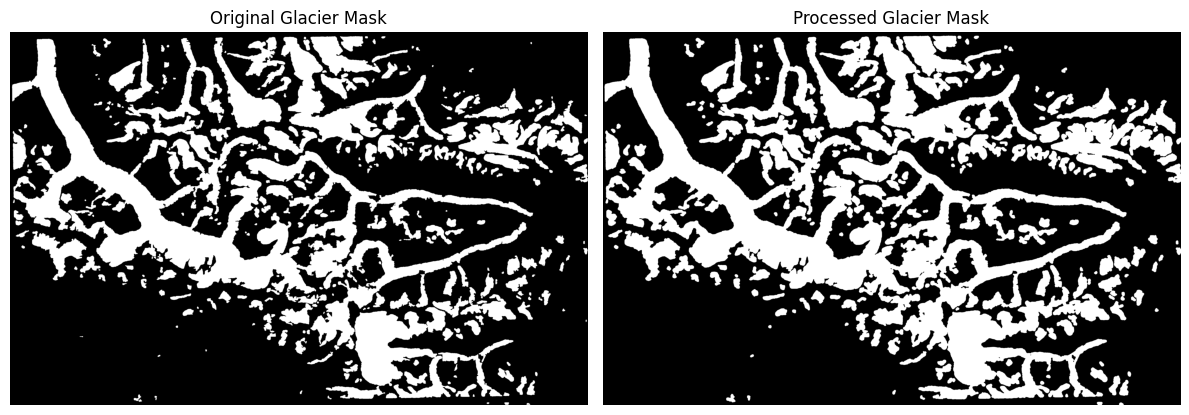

In [8]:
import matplotlib.pyplot as plt

# === Step 6: Visualize before and after ===
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original mask
axes[0].imshow(glacier_mask, cmap='gray')
axes[0].set_title('Original Glacier Mask')
axes[0].axis('off')

# Processed mask
axes[1].imshow(smooth_mask, cmap='gray')
axes[1].set_title('Processed Glacier Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()


Auto-calculated merge distance: 82.0 meters


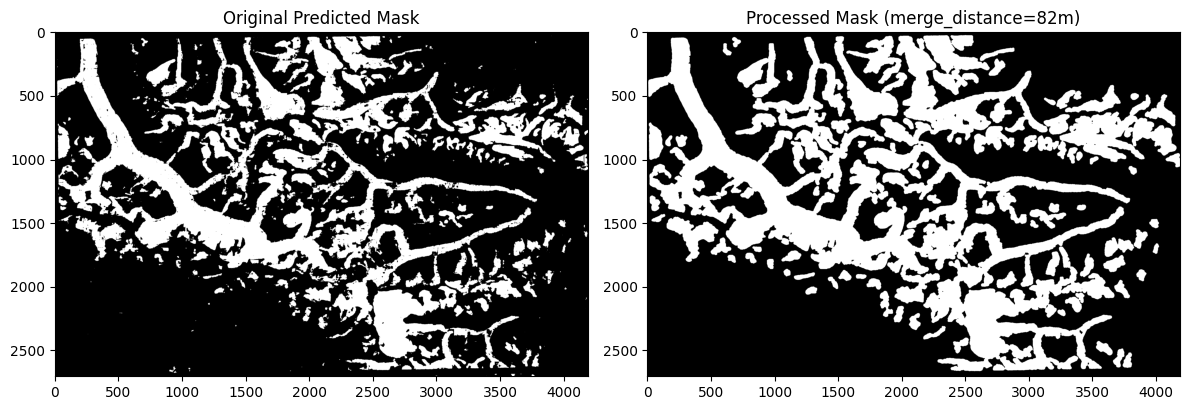

In [9]:
import rasterio
import numpy as np
from scipy.ndimage import label
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt

# === Input files ===
original_mask_path = "Z:/objective-1/original_mask/satopanth_mask.tif"
predicted_mask_path = "Z:/objective-1/sfs_results/glavitu/top_6/raster_satopanth_normalized_6band_cb_segnet.tif"
output_raster = "Z:/objective-1/glavitu/processing/raster_processed_new.tif"

pixel_resolution = 10  # in meters
min_area_km2 = 0.1
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))

# === Step 1: Load original and predicted masks ===
with rasterio.open(original_mask_path) as src:
    original_mask = src.read(1).astype(bool)
    
with rasterio.open(predicted_mask_path) as src:
    predicted_mask = src.read(1).astype(bool)
    profile = src.profile

# === Step 2: Measure fragmentation ===
# Remove small objects before labeling
predicted_mask_clean = remove_small_objects(predicted_mask, min_size=min_area_pixels)
original_mask_clean = remove_small_objects(original_mask, min_size=min_area_pixels)

labeled_pred, num_pred = label(predicted_mask_clean)
labeled_orig, num_orig = label(original_mask_clean)

# === Step 3: Auto-calculate merge distance ===
base_merge = 10  # Minimum
scale = 2.0      # Tuning factor
merge_distance_m = base_merge + scale * max(0, num_pred - num_orig)
merge_distance_m = min(max(merge_distance_m, 10), 100)  # Clamp between 10–100 m

print(f"Auto-calculated merge distance: {merge_distance_m} meters")

# === Step 4: Post-processing ===
from scipy.ndimage import binary_dilation, binary_erosion, distance_transform_edt
from skimage.morphology import closing, disk

cleaned_mask = remove_small_objects(predicted_mask, min_size=min_area_pixels)

# Merge regions
from scipy.ndimage import label
from skimage.morphology import binary_closing

distance = distance_transform_edt(~cleaned_mask)
merge_mask = distance <= (merge_distance_m / pixel_resolution)
merged_mask = np.logical_or(cleaned_mask, merge_mask)

# Fill gaps
filled_mask = binary_dilation(merged_mask, structure=np.ones((3,3)))
filled_mask = binary_erosion(filled_mask, structure=np.ones((3,3)))

# Smooth
smooth_mask = closing(filled_mask, disk(2))

# Save output
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(smooth_mask.astype(np.uint8), 1)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(predicted_mask, cmap='gray')
axes[0].set_title('Original Predicted Mask')
axes[1].imshow(smooth_mask, cmap='gray')
axes[1].set_title(f'Processed Mask (merge_distance={merge_distance_m:.0f}m)')
plt.tight_layout()
plt.show()


Fragmentation ratio: 1.23
Auto-scale factor: 1
Merge distance (m): 10
Iteration 1
Iteration 2
Iteration 3
IoU Before: 0.830, After: 0.859
Dice Before: 0.907, After: 0.924


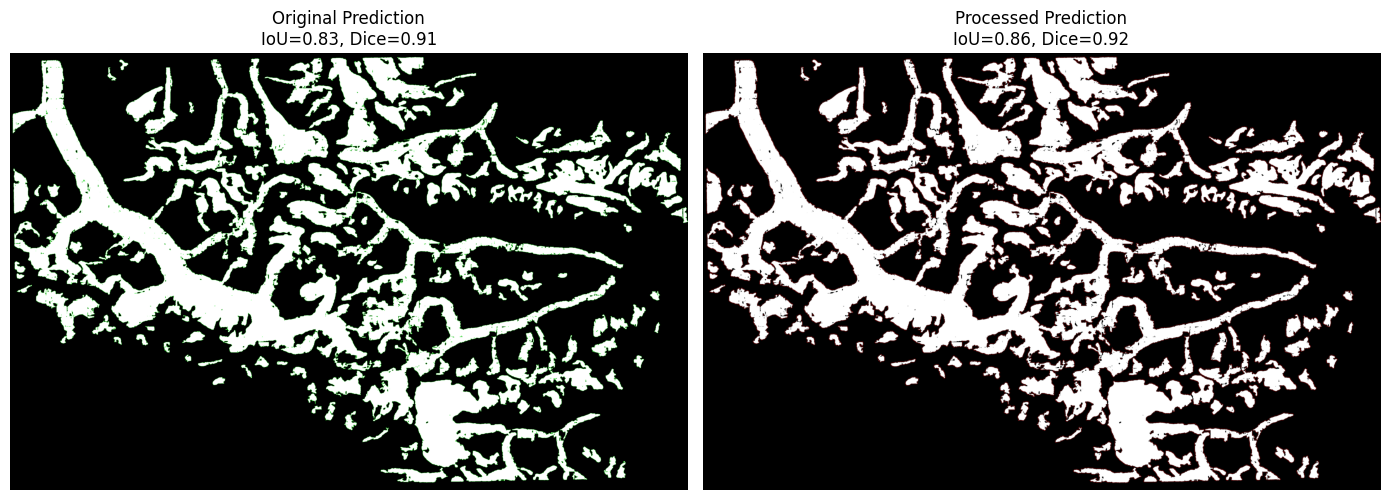

In [12]:
import rasterio
import numpy as np
from scipy.ndimage import label, binary_dilation, binary_erosion, distance_transform_edt
from skimage.morphology import remove_small_objects, closing, disk
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import cv2

# === Input Paths ===
original_mask_path = "Z:/objective-1/original_mask/satopanth_mask.tif"
predicted_mask_path = "Z:/objective-1/sfs_results/glavitu/top_6/raster_satopanth_normalized_6band_cb_segnet.tif"
output_raster = "Z:/objective-1/glavitu/processing/raster_processed_final_1.tif"

# === Parameters ===
pixel_resolution = 10  # in meters
min_area_km2 = 0.1
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
iterations = 3  # Number of smoothing/merging iterations

# === Load predicted mask ===
with rasterio.open(predicted_mask_path) as pred_src:
    predicted_mask = pred_src.read(1).astype(bool)
    profile = pred_src.profile
    pred_shape = predicted_mask.shape
    pred_transform = pred_src.transform
    pred_crs = pred_src.crs

# === Reproject original mask to match predicted raster ===
with rasterio.open(original_mask_path) as orig_src:
    original_data = orig_src.read(1)
    original_aligned = np.empty(pred_shape, dtype=original_data.dtype)

    reproject(
        source=original_data,
        destination=original_aligned,
        src_transform=orig_src.transform,
        src_crs=orig_src.crs,
        dst_transform=pred_transform,
        dst_crs=pred_crs,
        resampling=Resampling.nearest
    )

    original_mask = original_aligned.astype(bool)

# === Clean up masks (remove small speckles) ===
predicted_mask_clean = remove_small_objects(predicted_mask, min_size=min_area_pixels)
original_mask_clean = remove_small_objects(original_mask, min_size=min_area_pixels)

# === Fragmentation info ===
_, num_pred = label(predicted_mask_clean)
_, num_orig = label(original_mask_clean)
fragmentation_ratio = num_pred / max(num_orig, 1)

# === Adaptive merge distance ===
base_merge = 10  # in meters
auto_scale = 5 if fragmentation_ratio > 4 else 3 if fragmentation_ratio > 2 else 1
merge_distance_m = min(max(base_merge * auto_scale, 10), 100)

print(f"Fragmentation ratio: {fragmentation_ratio:.2f}")
print(f"Auto-scale factor: {auto_scale}")
print(f"Merge distance (m): {merge_distance_m}")

# === Iterative Post-processing ===
processed_mask = predicted_mask_clean.copy()
for i in range(iterations):
    print(f"Iteration {i+1}")
    distance = distance_transform_edt(~processed_mask)
    merge_mask = distance <= (merge_distance_m / pixel_resolution)
    merged_mask = np.logical_or(processed_mask, merge_mask)
    filled_mask = binary_dilation(merged_mask, structure=np.ones((3,3)))
    filled_mask = binary_erosion(filled_mask, structure=np.ones((3,3)))
    processed_mask = closing(filled_mask, disk(2))  # Smooth edges

# === Save the processed raster ===
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(processed_mask.astype(np.uint8), 1)

# === Evaluation Metrics ===
def compute_metrics(ref, pred):
    intersection = np.logical_and(ref, pred).sum()
    union = np.logical_or(ref, pred).sum()
    iou = intersection / union if union > 0 else 0.0
    dice = 2 * intersection / (ref.sum() + pred.sum()) if (ref.sum() + pred.sum()) > 0 else 0.0
    return iou, dice

iou_before, dice_before = compute_metrics(original_mask_clean, predicted_mask_clean)
iou_after, dice_after = compute_metrics(original_mask_clean, processed_mask)

print(f"IoU Before: {iou_before:.3f}, After: {iou_after:.3f}")
print(f"Dice Before: {dice_before:.3f}, After: {dice_after:.3f}")

# === Boundary Visualization ===
def overlay_boundaries(base, mask, color=(255, 0, 0)):
    overlay = np.stack([base * 255]*3, axis=-1).astype(np.uint8)
    contours = find_contours(mask.astype(float), 0.5)
    for contour in contours:
        contour = np.flip(np.array(contour), axis=1).astype(np.int32)
        cv2.polylines(overlay, [contour], isClosed=True, color=color, thickness=1)
    return overlay

vis_original = overlay_boundaries(predicted_mask_clean, predicted_mask_clean, color=(0, 255, 0))  # Green
vis_processed = overlay_boundaries(predicted_mask_clean, processed_mask, color=(255, 0, 0))       # Red

# === Show Comparison ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(vis_original)
axes[0].set_title(f"Original Prediction\nIoU={iou_before:.2f}, Dice={dice_before:.2f}")
axes[1].imshow(vis_processed)
axes[1].set_title(f"Processed Prediction\nIoU={iou_after:.2f}, Dice={dice_after:.2f}")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()

Fragmentation ratio: 1.23
Auto-scale factor: 1
Merge distance (m): 10
Iteration 01: IoU = 0.8563, Dice = 0.9226
Iteration 02: IoU = 0.8618, Dice = 0.9258
Iteration 03: IoU = 0.8588, Dice = 0.9240
Iteration 04: IoU = 0.8506, Dice = 0.9193
Iteration 05: IoU = 0.8394, Dice = 0.9127
Iteration 06: IoU = 0.8265, Dice = 0.9050
Iteration 07: IoU = 0.8125, Dice = 0.8966
Iteration 08: IoU = 0.7982, Dice = 0.8878
Iteration 09: IoU = 0.7840, Dice = 0.8789
Iteration 10: IoU = 0.7700, Dice = 0.8700
Iteration 11: IoU = 0.7562, Dice = 0.8612
Iteration 12: IoU = 0.7426, Dice = 0.8523
Iteration 13: IoU = 0.7295, Dice = 0.8436
Iteration 14: IoU = 0.7167, Dice = 0.8350
Iteration 15: IoU = 0.7044, Dice = 0.8266
Iteration 16: IoU = 0.6926, Dice = 0.8184
Iteration 17: IoU = 0.6813, Dice = 0.8104
Iteration 18: IoU = 0.6704, Dice = 0.8027
Iteration 19: IoU = 0.6600, Dice = 0.7952
Iteration 20: IoU = 0.6501, Dice = 0.7879
Iteration 21: IoU = 0.6406, Dice = 0.7809
Iteration 22: IoU = 0.6315, Dice = 0.7741
Iterat

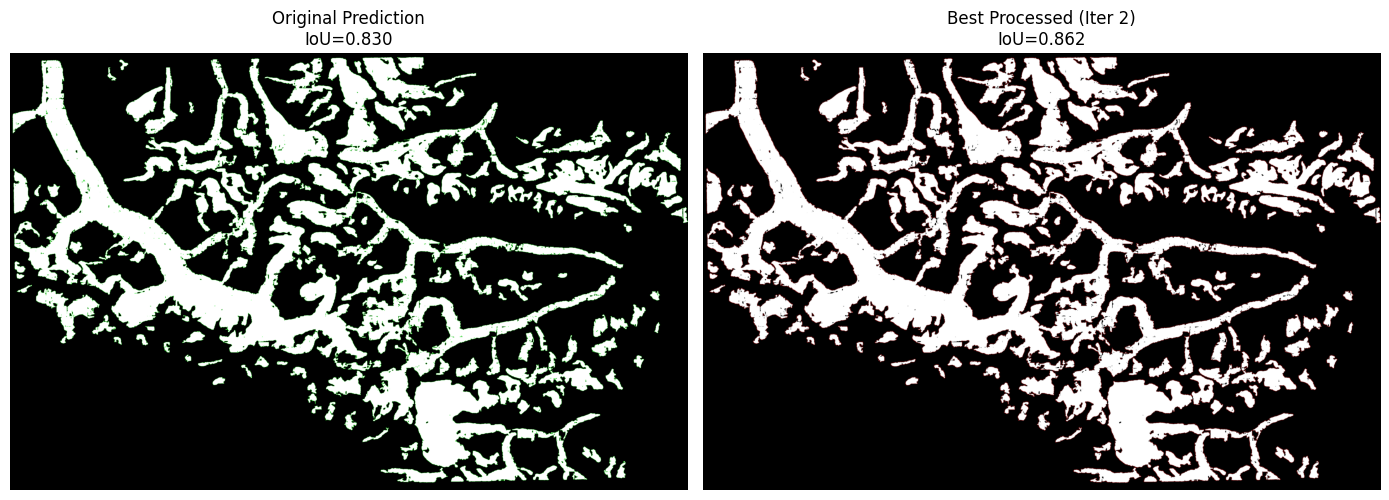

In [14]:
import rasterio
import numpy as np
from scipy.ndimage import label, binary_dilation, binary_erosion, distance_transform_edt
from skimage.morphology import remove_small_objects, closing, disk
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import cv2

# === Input Paths ===
original_mask_path = "Z:/objective-1/original_mask/satopanth_mask.tif"
predicted_mask_path = "Z:/objective-1/sfs_results/glavitu/top_6/raster_satopanth_normalized_6band_cb_segnet.tif"
output_raster = "Z:/objective-1/glavitu/processing/raster_processed_best_1.tif"

# === Parameters ===
pixel_resolution = 10  # in meters
min_area_km2 = 0.1
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
max_iterations = 30  # Max number of post-processing iterations

# === Load predicted mask ===
with rasterio.open(predicted_mask_path) as pred_src:
    predicted_mask = pred_src.read(1).astype(bool)
    profile = pred_src.profile
    pred_shape = predicted_mask.shape
    pred_transform = pred_src.transform
    pred_crs = pred_src.crs

# === Reproject original mask to match predicted raster ===
with rasterio.open(original_mask_path) as orig_src:
    original_data = orig_src.read(1)
    original_aligned = np.empty(pred_shape, dtype=original_data.dtype)

    reproject(
        source=original_data,
        destination=original_aligned,
        src_transform=orig_src.transform,
        src_crs=orig_src.crs,
        dst_transform=pred_transform,
        dst_crs=pred_crs,
        resampling=Resampling.nearest
    )

    original_mask = original_aligned.astype(bool)

# === Clean up masks ===
predicted_mask_clean = remove_small_objects(predicted_mask, min_size=min_area_pixels)
original_mask_clean = remove_small_objects(original_mask, min_size=min_area_pixels)

# === Fragmentation info ===
_, num_pred = label(predicted_mask_clean)
_, num_orig = label(original_mask_clean)
fragmentation_ratio = num_pred / max(num_orig, 1)

# === Adaptive merge distance ===
base_merge = 10  # meters
auto_scale = 5 if fragmentation_ratio > 4 else 3 if fragmentation_ratio > 2 else 1
merge_distance_m = min(max(base_merge * auto_scale, 10), 100)

print(f"Fragmentation ratio: {fragmentation_ratio:.2f}")
print(f"Auto-scale factor: {auto_scale}")
print(f"Merge distance (m): {merge_distance_m}")

# === Metrics function ===
def compute_metrics(ref, pred):
    intersection = np.logical_and(ref, pred).sum()
    union = np.logical_or(ref, pred).sum()
    iou = intersection / union if union > 0 else 0.0
    dice = 2 * intersection / (ref.sum() + pred.sum()) if (ref.sum() + pred.sum()) > 0 else 0.0
    return iou, dice

# === Iterative Post-processing to Maximize IoU ===
best_iou = -1
best_mask = None
best_iter = 0
iou_scores = []

processed_mask = predicted_mask_clean.copy()
for i in range(1, max_iterations + 1):
    distance = distance_transform_edt(~processed_mask)
    merge_mask = distance <= (merge_distance_m / pixel_resolution)
    merged_mask = np.logical_or(processed_mask, merge_mask)
    filled_mask = binary_dilation(merged_mask, structure=np.ones((3, 3)))
    filled_mask = binary_erosion(filled_mask, structure=np.ones((3, 3)))
    processed_mask = closing(filled_mask, disk(2))  # Smooth

    iou, dice = compute_metrics(original_mask_clean, processed_mask)
    iou_scores.append((i, iou, dice))
    
    print(f"Iteration {i:02d}: IoU = {iou:.4f}, Dice = {dice:.4f}")

    if iou > best_iou:
        best_iou = iou
        best_mask = processed_mask.copy()
        best_iter = i

# === Save best result ===
print(f"\nBest IoU: {best_iou:.4f} at iteration {best_iter}")
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(best_mask.astype(np.uint8), 1)

# === Boundary Overlay Visualization ===
def overlay_boundaries(base, mask, color=(255, 0, 0)):
    overlay = np.stack([base * 255] * 3, axis=-1).astype(np.uint8)
    contours = find_contours(mask.astype(float), 0.5)
    for contour in contours:
        contour = np.flip(np.array(contour), axis=1).astype(np.int32)
        cv2.polylines(overlay, [contour], isClosed=True, color=color, thickness=1)
    return overlay

vis_original = overlay_boundaries(predicted_mask_clean, predicted_mask_clean, color=(0, 255, 0))  # Green
vis_best = overlay_boundaries(predicted_mask_clean, best_mask, color=(255, 0, 0))                 # Red

# === Show Visualization ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(vis_original)
axes[0].set_title(f"Original Prediction\nIoU={compute_metrics(original_mask_clean, predicted_mask_clean)[0]:.3f}")
axes[1].imshow(vis_best)
axes[1].set_title(f"Best Processed (Iter {best_iter})\nIoU={best_iou:.3f}")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()


Fragmentation ratio: 1.23
Auto-scale factor: 1
Merge distance (m): 10
Iteration 01: IoU = 0.8564, Dice = 0.9226
Iteration 02: IoU = 0.8354, Dice = 0.9103
Iteration 03: IoU = 0.8324, Dice = 0.9085
Iteration 04: IoU = 0.8253, Dice = 0.9043
Iteration 05: IoU = 0.8139, Dice = 0.8974
Iteration 06: IoU = 0.7991, Dice = 0.8883
Iteration 07: IoU = 0.7851, Dice = 0.8796
Iteration 08: IoU = 0.7728, Dice = 0.8718
Iteration 09: IoU = 0.7341, Dice = 0.8466
Iteration 10: IoU = 0.7230, Dice = 0.8392
Iteration 11: IoU = 0.7039, Dice = 0.8262
Iteration 12: IoU = 0.6940, Dice = 0.8194
Iteration 13: IoU = 0.6844, Dice = 0.8126
Iteration 14: IoU = 0.6623, Dice = 0.7969
Iteration 15: IoU = 0.6502, Dice = 0.7881
Iteration 16: IoU = 0.6293, Dice = 0.7725
Iteration 17: IoU = 0.6205, Dice = 0.7658
Iteration 18: IoU = 0.6128, Dice = 0.7599
Iteration 19: IoU = 0.5851, Dice = 0.7382
Iteration 20: IoU = 0.5737, Dice = 0.7291
Iteration 21: IoU = 0.5639, Dice = 0.7212
Iteration 22: IoU = 0.5592, Dice = 0.7173
Iterat

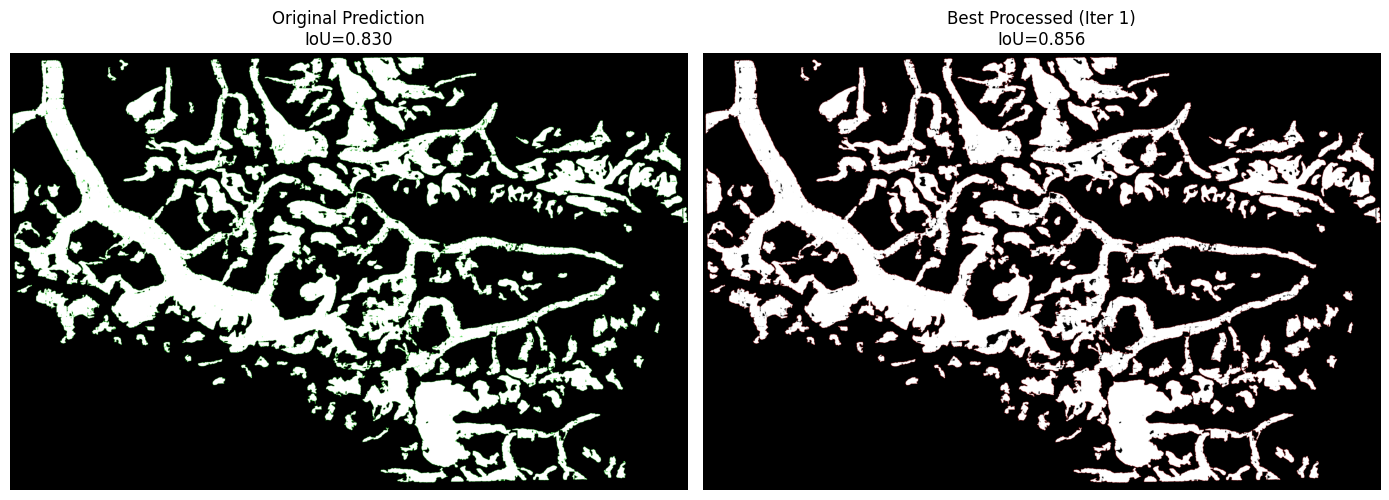

In [15]:
import rasterio
import numpy as np
from scipy.ndimage import label, binary_dilation, binary_erosion, distance_transform_edt, binary_fill_holes
from skimage.morphology import remove_small_objects, closing, disk
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import cv2

# === Input Paths ===
original_mask_path = "Z:/objective-1/original_mask/satopanth_mask.tif"
predicted_mask_path = "Z:/objective-1/sfs_results/glavitu/top_6/raster_satopanth_normalized_6band_cb_segnet.tif"
output_raster = "Z:/objective-1/glavitu/processing/raster_processed_best_1.tif"

# === Parameters ===
pixel_resolution = 10  # in meters
min_area_km2 = 0.1
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
max_iterations = 30  # Max number of post-processing iterations

# === Load predicted mask ===
with rasterio.open(predicted_mask_path) as pred_src:
    predicted_mask = pred_src.read(1).astype(bool)
    profile = pred_src.profile
    pred_shape = predicted_mask.shape
    pred_transform = pred_src.transform
    pred_crs = pred_src.crs

# === Reproject original mask to match predicted raster ===
with rasterio.open(original_mask_path) as orig_src:
    original_data = orig_src.read(1)
    original_aligned = np.empty(pred_shape, dtype=original_data.dtype)

    reproject(
        source=original_data,
        destination=original_aligned,
        src_transform=orig_src.transform,
        src_crs=orig_src.crs,
        dst_transform=pred_transform,
        dst_crs=pred_crs,
        resampling=Resampling.nearest
    )

    original_mask = original_aligned.astype(bool)

# === Clean up masks ===
predicted_mask_clean = remove_small_objects(predicted_mask, min_size=min_area_pixels)
original_mask_clean = remove_small_objects(original_mask, min_size=min_area_pixels)

# === Fragmentation info ===
_, num_pred = label(predicted_mask_clean)
_, num_orig = label(original_mask_clean)
fragmentation_ratio = num_pred / max(num_orig, 1)

# === Adaptive merge distance ===
base_merge = 10  # meters
auto_scale = 5 if fragmentation_ratio > 4 else 3 if fragmentation_ratio > 2 else 1
merge_distance_m = min(max(base_merge * auto_scale, 10), 100)

print(f"Fragmentation ratio: {fragmentation_ratio:.2f}")
print(f"Auto-scale factor: {auto_scale}")
print(f"Merge distance (m): {merge_distance_m}")

# === Metrics function ===
def compute_metrics(ref, pred):
    intersection = np.logical_and(ref, pred).sum()
    union = np.logical_or(ref, pred).sum()
    iou = intersection / union if union > 0 else 0.0
    dice = 2 * intersection / (ref.sum() + pred.sum()) if (ref.sum() + pred.sum()) > 0 else 0.0
    return iou, dice

# === Iterative Post-processing to Maximize IoU ===
best_iou = -1
best_mask = None
best_iter = 0
iou_scores = []

processed_mask = predicted_mask_clean.copy()
for i in range(1, max_iterations + 1):
    distance = distance_transform_edt(~processed_mask)
    merge_mask = distance <= (merge_distance_m / pixel_resolution)
    merged_mask = np.logical_or(processed_mask, merge_mask)

    # Smooth boundaries
    filled_mask = binary_dilation(merged_mask, structure=np.ones((3, 3)))
    filled_mask = binary_erosion(filled_mask, structure=np.ones((3, 3)))
    smoothed = closing(filled_mask, disk(2))

    # Fill internal holes
    processed_mask = binary_fill_holes(smoothed)

    # Evaluate performance
    iou, dice = compute_metrics(original_mask_clean, processed_mask)
    iou_scores.append((i, iou, dice))
    
    print(f"Iteration {i:02d}: IoU = {iou:.4f}, Dice = {dice:.4f}")

    if iou > best_iou:
        best_iou = iou
        best_mask = processed_mask.copy()
        best_iter = i

# === Save best result ===
print(f"\nBest IoU: {best_iou:.4f} at iteration {best_iter}")
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(best_mask.astype(np.uint8), 1)

# === Boundary Overlay Visualization ===
def overlay_boundaries(base, mask, color=(255, 0, 0)):
    overlay = np.stack([base * 255] * 3, axis=-1).astype(np.uint8)
    contours = find_contours(mask.astype(float), 0.5)
    for contour in contours:
        contour = np.flip(np.array(contour), axis=1).astype(np.int32)
        cv2.polylines(overlay, [contour], isClosed=True, color=color, thickness=1)
    return overlay

vis_original = overlay_boundaries(predicted_mask_clean, predicted_mask_clean, color=(0, 255, 0))  # Green
vis_best = overlay_boundaries(predicted_mask_clean, best_mask, color=(255, 0, 0))                 # Red

# === Show Visualization ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(vis_original)
axes[0].set_title(f"Original Prediction\nIoU={compute_metrics(original_mask_clean, predicted_mask_clean)[0]:.3f}")
axes[1].imshow(vis_best)
axes[1].set_title(f"Best Processed (Iter {best_iter})\nIoU={best_iou:.3f}")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()


In [17]:
#pip install tqdm

     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.7 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.7 kB 129.6 kB/s eta 0:00:01
     ------------- ------------------------ 20.5/57.7 kB 129.6 kB/s eta 0:00:01
     -------------------------- ----------- 41.0/57.7 kB 178.6 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.7 kB 217.9 kB/s eta 0:00:01
     -------------------------------------- 57.7/57.7 kB 178.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ------------------------------------ --- 71.7/78.5 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 78.5/78.5 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Loading and preprocessing data...
Predicted mask shape: (2705, 4189)
Original mask shape: (2705, 4189)
Predicted mask coverage: 2989080 pixels
Original mask coverage: 3489537 pixels
Initial IoU: 0.8307, Dice: 0.9075
Fragmentation ratio: 1.41
Testing 18 smart parameter combinations...
Testing 1/18: base=10, scale=2, limit=75
  New best IoU: 0.8575
Testing 2/18: base=10, scale=2, limit=100
Testing 3/18: base=10, scale=3, limit=75
Testing 4/18: base=10, scale=3, limit=100
Testing 5/18: base=10, scale=4, limit=75
Testing 6/18: base=10, scale=4, limit=100
Testing 7/18: base=15, scale=2, limit=75
Testing 8/18: base=15, scale=2, limit=100
Testing 9/18: base=15, scale=3, limit=75
Testing 10/18: base=15, scale=3, limit=100
Testing 11/18: base=15, scale=4, limit=75
Testing 12/18: base=15, scale=4, limit=100
Testing 13/18: base=20, scale=2, limit=75
Testing 14/18: base=20, scale=2, limit=100
Testing 15/18: base=20, scale=3, limit=75
Testing 16/18: base=20, scale=3, limit=100
Testing 17/18: base=2

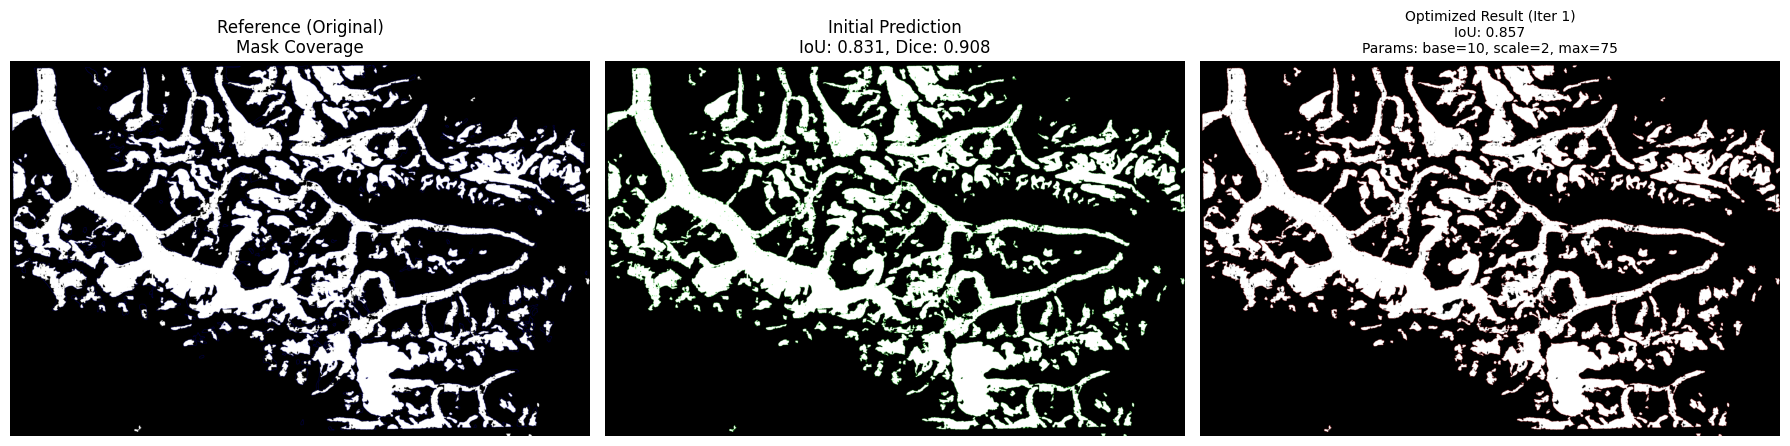

Parameter analysis saved to: Z:/objective-1/glavitu/processing/raster_processed_best_optimized_parameter_analysis.txt

Optimization complete!


In [2]:
import rasterio
import numpy as np
from scipy.ndimage import label, binary_dilation, binary_erosion, distance_transform_edt, binary_fill_holes
from skimage.morphology import remove_small_objects, closing, disk
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import cv2
from multiprocessing import Pool, cpu_count
from functools import partial
import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# === Input Paths ===
original_mask_path = "Z:/objective-1/original_mask/satopanth_mask.tif"
predicted_mask_path = "Z:/objective-1/sfs_results/glavitu/top_6/raster_satopanth_normalized_6band_cb_segnet.tif"
output_raster = "Z:/objective-1/glavitu/processing/raster_processed_best_optimized.tif"

# === Parameters ===
pixel_resolution = 10  # in meters
min_area_km2 = 0.02
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
max_iterations = 10  # Reduced for faster processing

# === Parameter Grid for Optimization (Reduced for speed) ===
BASE_MERGE_RANGE = [10, 15, 20, 25]  # Base merge distances in meters
AUTO_SCALE_RANGE = [2, 3, 4, 5]      # Auto-scale factors
MAX_MERGE_LIMITS = [75, 100, 125]    # Maximum merge distance limits

# === Load and preprocess data ===
def load_and_preprocess_data():
    """Load and align the predicted and original masks"""
    # Load predicted mask
    with rasterio.open(predicted_mask_path) as pred_src:
        predicted_mask = pred_src.read(1).astype(bool)
        profile = pred_src.profile
        pred_shape = predicted_mask.shape
        pred_transform = pred_src.transform
        pred_crs = pred_src.crs

    # Reproject original mask to match predicted raster
    with rasterio.open(original_mask_path) as orig_src:
        original_data = orig_src.read(1)
        original_aligned = np.empty(pred_shape, dtype=original_data.dtype)

        reproject(
            source=original_data,
            destination=original_aligned,
            src_transform=orig_src.transform,
            src_crs=orig_src.crs,
            dst_transform=pred_transform,
            dst_crs=pred_crs,
            resampling=Resampling.nearest
        )
        original_mask = original_aligned.astype(bool)

    # Clean up masks
    predicted_mask_clean = remove_small_objects(predicted_mask, min_size=min_area_pixels)
    original_mask_clean = remove_small_objects(original_mask, min_size=min_area_pixels)

    return predicted_mask_clean, original_mask_clean, profile

# === Metrics function ===
def compute_metrics(ref, pred):
    """Compute IoU and Dice scores"""
    intersection = np.logical_and(ref, pred).sum()
    union = np.logical_or(ref, pred).sum()
    iou = intersection / union if union > 0 else 0.0
    dice = 2 * intersection / (ref.sum() + pred.sum()) if (ref.sum() + pred.sum()) > 0 else 0.0
    return iou, dice

# === Gap filling with adaptive parameters ===
def fill_gaps_adaptive(predicted_mask, original_mask, base_merge, auto_scale_factor, max_merge_limit):
    """Fill gaps in predicted mask using adaptive parameters"""
    # Calculate fragmentation ratio
    _, num_pred = label(predicted_mask)
    _, num_orig = label(original_mask)
    fragmentation_ratio = num_pred / max(num_orig, 1)
    
    # Calculate adaptive merge distance
    auto_scale = auto_scale_factor if fragmentation_ratio > 2 else max(1, auto_scale_factor - 2)
    merge_distance_m = min(max(base_merge * auto_scale, base_merge), max_merge_limit)
    merge_distance_pixels = merge_distance_m / pixel_resolution
    
    best_iou = -1
    best_mask = None
    best_iter = 0
    
    processed_mask = predicted_mask.copy()
    
    # Get initial IoU for early stopping
    initial_iou, _ = compute_metrics(original_mask, processed_mask)
    best_iou = initial_iou
    best_mask = processed_mask.copy()
    
    for i in range(1, max_iterations + 1):
        # Distance-based gap filling
        distance = distance_transform_edt(~processed_mask)
        merge_mask = distance <= merge_distance_pixels
        merged_mask = np.logical_or(processed_mask, merge_mask)

        # Morphological operations for smoothing
        filled_mask = binary_dilation(merged_mask, structure=np.ones((3, 3)))
        filled_mask = binary_erosion(filled_mask, structure=np.ones((3, 3)))
        smoothed = closing(filled_mask, disk(2))

        # Fill internal holes
        processed_mask = binary_fill_holes(smoothed)

        # Evaluate performance
        iou, dice = compute_metrics(original_mask, processed_mask)
        
        if iou > best_iou:
            best_iou = iou
            best_mask = processed_mask.copy()
            best_iter = i
        
        # Early stopping conditions
        if i > 3 and (i - best_iter) > 2:  # Stop if no improvement for 2 iterations
            break
        if iou > 0.98:  # Stop if very high IoU achieved
            break
    
    return best_iou, best_mask, best_iter, merge_distance_m, fragmentation_ratio

# === Parallel processing function ===
def process_parameter_combination(params, predicted_mask, original_mask):
    """Process a single parameter combination"""
    base_merge, auto_scale_factor, max_merge_limit = params
    
    try:
        iou, mask, iter_num, merge_dist, frag_ratio = fill_gaps_adaptive(
            predicted_mask, original_mask, base_merge, auto_scale_factor, max_merge_limit
        )
        
        return {
            'base_merge': base_merge,
            'auto_scale': auto_scale_factor,
            'max_merge_limit': max_merge_limit,
            'iou': iou,
            'best_mask': mask,
            'best_iter': iter_num,
            'merge_distance': merge_dist,
            'fragmentation_ratio': frag_ratio
        }
    except Exception as e:
        return {
            'base_merge': base_merge,
            'auto_scale': auto_scale_factor,
            'max_merge_limit': max_merge_limit,
            'iou': -1,
            'error': str(e)
        }

# === Fast parameter optimization with smart selection ===
def quick_parameter_optimization(predicted_mask, original_mask):
    """Quick parameter optimization using smart heuristics"""
    
    # Calculate initial fragmentation to guide parameter selection
    _, num_pred = label(predicted_mask)
    _, num_orig = label(original_mask)
    fragmentation_ratio = num_pred / max(num_orig, 1)
    
    print(f"Fragmentation ratio: {fragmentation_ratio:.2f}")
    
    # Smart parameter selection based on fragmentation
    if fragmentation_ratio > 4:
        # High fragmentation - need aggressive merging
        base_candidates = [20, 25, 30]
        scale_candidates = [4, 5, 6]
        limit_candidates = [100, 125]
    elif fragmentation_ratio > 2:
        # Medium fragmentation
        base_candidates = [15, 20, 25]
        scale_candidates = [3, 4, 5]
        limit_candidates = [75, 100, 125]
    else:
        # Low fragmentation - gentle processing
        base_candidates = [10, 15, 20]
        scale_candidates = [2, 3, 4]
        limit_candidates = [75, 100]
    
    # Test smart combinations
    param_combinations = list(itertools.product(base_candidates, scale_candidates, limit_candidates))
    
    print(f"Testing {len(param_combinations)} smart parameter combinations...")
    
    best_result = {'iou': -1}
    results = []
    
    for i, (base_merge, auto_scale, max_limit) in enumerate(param_combinations):
        print(f"Testing {i+1}/{len(param_combinations)}: base={base_merge}, scale={auto_scale}, limit={max_limit}")
        
        iou, mask, iter_num, merge_dist, frag_ratio = fill_gaps_adaptive(
            predicted_mask, original_mask, base_merge, auto_scale, max_limit
        )
        
        result = {
            'base_merge': base_merge,
            'auto_scale': auto_scale,
            'max_merge_limit': max_limit,
            'iou': iou,
            'best_mask': mask,
            'best_iter': iter_num,
            'merge_distance': merge_dist,
            'fragmentation_ratio': frag_ratio
        }
        
        results.append(result)
        
        if iou > best_result['iou']:
            best_result = result
            print(f"  New best IoU: {iou:.4f}")
    
    return best_result, results

# === Visualization functions ===
def overlay_boundaries(base, mask, color=(255, 0, 0)):
    """Create boundary overlay visualization"""
    overlay = np.stack([base * 255] * 3, axis=-1).astype(np.uint8)
    contours = find_contours(mask.astype(float), 0.5)
    for contour in contours:
        contour = np.flip(np.array(contour), axis=1).astype(np.int32)
        cv2.polylines(overlay, [contour], isClosed=True, color=color, thickness=1)
    return overlay

def create_comparison_plot(predicted_mask, original_mask, best_result):
    """Create comparison visualization"""
    # Original prediction metrics
    orig_iou, orig_dice = compute_metrics(original_mask, predicted_mask)
    
    # Create overlays
    vis_original = overlay_boundaries(predicted_mask, predicted_mask, color=(0, 255, 0))  # Green
    vis_best = overlay_boundaries(predicted_mask, best_result['best_mask'], color=(255, 0, 0))  # Red
    vis_reference = overlay_boundaries(predicted_mask, original_mask, color=(0, 0, 255))  # Blue
    
    # Create plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(vis_reference)
    axes[0].set_title(f"Reference (Original)\nMask Coverage", fontsize=12)
    
    axes[1].imshow(vis_original)
    axes[1].set_title(f"Initial Prediction\nIoU: {orig_iou:.3f}, Dice: {orig_dice:.3f}", fontsize=12)
    
    axes[2].imshow(vis_best)
    axes[2].set_title(f"Optimized Result (Iter {best_result['best_iter']})\n" + 
                     f"IoU: {best_result['iou']:.3f}\n" +
                     f"Params: base={best_result['base_merge']}, scale={best_result['auto_scale']}, max={best_result['max_merge_limit']}", 
                     fontsize=10)
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    return fig

# === Main execution ===
if __name__ == "__main__":
    print("Loading and preprocessing data...")
    predicted_mask_clean, original_mask_clean, profile = load_and_preprocess_data()
    
    print(f"Predicted mask shape: {predicted_mask_clean.shape}")
    print(f"Original mask shape: {original_mask_clean.shape}")
    print(f"Predicted mask coverage: {predicted_mask_clean.sum()} pixels")
    print(f"Original mask coverage: {original_mask_clean.sum()} pixels")
    
    # Initial metrics
    initial_iou, initial_dice = compute_metrics(original_mask_clean, predicted_mask_clean)
    print(f"Initial IoU: {initial_iou:.4f}, Dice: {initial_dice:.4f}")
    
    # Optimize parameters (using fast method)
    best_result, all_results = quick_parameter_optimization(predicted_mask_clean, original_mask_clean)
    
    # Print optimal parameters
    print(f"\nOptimal Parameters Found:")
    print(f"Base merge distance: {best_result['base_merge']} meters")
    print(f"Auto-scale factor: {best_result['auto_scale']}")
    print(f"Max merge limit: {best_result['max_merge_limit']} meters")
    print(f"Actual merge distance used: {best_result['merge_distance']:.1f} meters")
    print(f"Fragmentation ratio: {best_result['fragmentation_ratio']:.2f}")
    print(f"Best IoU achieved: {best_result['iou']:.4f}")
    print(f"IoU improvement: {best_result['iou'] - initial_iou:.4f}")
    
    # Save best result
    print(f"\nSaving optimized result to: {output_raster}")
    profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
    with rasterio.open(output_raster, 'w', **profile) as dst:
        dst.write(best_result['best_mask'].astype(np.uint8), 1)
    
    # Create and show visualization
    fig = create_comparison_plot(predicted_mask_clean, original_mask_clean, best_result)
    plt.show()
    
    # Save parameter analysis
    analysis_file = output_raster.replace('.tif', '_parameter_analysis.txt')
    with open(analysis_file, 'w') as f:
        f.write("Parameter Optimization Analysis\n")
        f.write("================================\n\n")
        f.write(f"Initial IoU: {initial_iou:.4f}\n")
        f.write(f"Best IoU: {best_result['iou']:.4f}\n")
        f.write(f"Improvement: {best_result['iou'] - initial_iou:.4f}\n\n")
        f.write("Optimal Parameters:\n")
        f.write(f"- Base merge distance: {best_result['base_merge']} meters\n")
        f.write(f"- Auto-scale factor: {best_result['auto_scale']}\n")
        f.write(f"- Max merge limit: {best_result['max_merge_limit']} meters\n")
        f.write(f"- Actual merge distance: {best_result['merge_distance']:.1f} meters\n")
        f.write(f"- Fragmentation ratio: {best_result['fragmentation_ratio']:.2f}\n")
        f.write(f"- Best iteration: {best_result['best_iter']}\n\n")
        f.write("Top 10 Parameter Combinations:\n")
        sorted_results = sorted(all_results, key=lambda x: x['iou'], reverse=True)[:10]
        for i, result in enumerate(sorted_results, 1):
            f.write(f"{i:2d}. IoU={result['iou']:.4f} | base={result['base_merge']:2d} | scale={result['auto_scale']} | max={result['max_merge_limit']:3d}\n")
    
    print(f"Parameter analysis saved to: {analysis_file}")
    print("\nOptimization complete!")

In [ ]:
import rasterio
import numpy as np
from scipy.ndimage import label, binary_dilation, binary_erosion, distance_transform_edt, binary_fill_holes
from skimage.morphology import remove_small_objects, closing, disk, opening
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from skimage.measure import find_contours, regionprops
import cv2
from multiprocessing import Pool, cpu_count
from functools import partial
import itertools
from tqdm import tqdm
import warnings
from scipy.spatial.distance import cdist
warnings.filterwarnings('ignore')

# === Input Paths ===
original_mask_path = "Z:/objective-1/original_mask/satopanth_mask.tif"
predicted_mask_path = "Z:/objective-1/sfs_results/glavitu/top_6/raster_satopanth_normalized_6band_cb_segnet.tif"
output_raster = "Z:/objective-1/glavitu/processing/raster_processed_glacier_connected.tif"

# === Parameters ===
pixel_resolution = 10  # in meters
min_area_km2 = 0.02  # Reduced minimum area for glacier segments
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))

print(f"Minimum area: {min_area_km2} km² = {min_area_pixels} pixels")

# === Load and preprocess data ===
def load_and_preprocess_data():
    """Load and align the predicted and original masks"""
    # Load predicted mask
    with rasterio.open(predicted_mask_path) as pred_src:
        predicted_mask = pred_src.read(1).astype(bool)
        profile = pred_src.profile
        pred_shape = predicted_mask.shape
        pred_transform = pred_src.transform
        pred_crs = pred_src.crs

    # Reproject original mask to match predicted raster
    with rasterio.open(original_mask_path) as orig_src:
        original_data = orig_src.read(1)
        original_aligned = np.empty(pred_shape, dtype=original_data.dtype)

        reproject(
            source=original_data,
            destination=original_aligned,
            src_transform=orig_src.transform,
            src_crs=orig_src.crs,
            dst_transform=pred_transform,
            dst_crs=pred_crs,
            resampling=Resampling.nearest
        )
        original_mask = original_aligned.astype(bool)

    # Clean up masks
    predicted_mask_clean = remove_small_objects(predicted_mask, min_size=min_area_pixels)
    original_mask_clean = remove_small_objects(original_mask, min_size=min_area_pixels)

    return predicted_mask_clean, original_mask_clean, profile

# === Glacier connectivity analysis ===
def analyze_glacier_connectivity(mask):
    """Analyze glacier fragmentation and connectivity"""
    labeled_mask, num_components = label(mask)
    
    if num_components == 0:
        return {
            'num_components': 0,
            'total_area': 0,
            'largest_component_ratio': 0,
            'avg_component_size': 0,
            'fragmentation_index': 0,
            'min_gap_distance': 0,
            'max_gap_distance': 0,
            'avg_gap_distance': 0
        }
    
    # Component analysis
    component_sizes = []
    centroids = []
    
    for i in range(1, num_components + 1):
        component_mask = (labeled_mask == i)
        size = np.sum(component_mask)
        component_sizes.append(size)
        
        # Calculate centroid
        y_coords, x_coords = np.where(component_mask)
        centroid = (np.mean(y_coords), np.mean(x_coords))
        centroids.append(centroid)
    
    component_sizes = np.array(component_sizes)
    total_area = np.sum(component_sizes)
    largest_component_ratio = np.max(component_sizes) / total_area if total_area > 0 else 0
    avg_component_size = np.mean(component_sizes)
    
    # Fragmentation index (higher = more fragmented)
    fragmentation_index = num_components / (total_area / 10000)  # components per 10k pixels
    
    # Gap distance analysis
    gap_distances = []
    if len(centroids) > 1:
        centroid_array = np.array(centroids)
        distances = cdist(centroid_array, centroid_array)
        # Get upper triangle (excluding diagonal)
        upper_tri_indices = np.triu_indices(len(centroids), k=1)
        gap_distances = distances[upper_tri_indices] * pixel_resolution  # Convert to meters
    
    min_gap_distance = np.min(gap_distances) if len(gap_distances) > 0 else 0
    max_gap_distance = np.max(gap_distances) if len(gap_distances) > 0 else 0
    avg_gap_distance = np.mean(gap_distances) if len(gap_distances) > 0 else 0
    
    return {
        'num_components': num_components,
        'total_area': total_area,
        'largest_component_ratio': largest_component_ratio,
        'avg_component_size': avg_component_size,
        'fragmentation_index': fragmentation_index,
        'min_gap_distance': min_gap_distance,
        'max_gap_distance': max_gap_distance,
        'avg_gap_distance': avg_gap_distance,
        'component_sizes': component_sizes
    }

# === Automated parameter selection ===
def auto_select_parameters(predicted_mask, original_mask):
    """Automatically select optimal parameters based on glacier characteristics"""
    
    pred_stats = analyze_glacier_connectivity(predicted_mask)
    orig_stats = analyze_glacier_connectivity(original_mask)
    
    print(f"\nGlacier Connectivity Analysis:")
    print(f"Predicted mask: {pred_stats['num_components']} components")
    print(f"Original mask: {orig_stats['num_components']} components")
    print(f"Fragmentation index: {pred_stats['fragmentation_index']:.2f}")
    print(f"Average gap distance: {pred_stats['avg_gap_distance']:.1f} meters")
    print(f"Min gap distance: {pred_stats['min_gap_distance']:.1f} meters")
    print(f"Max gap distance: {pred_stats['max_gap_distance']:.1f} meters")
    
    # Determine optimal parameters based on analysis
    fragmentation_ratio = pred_stats['num_components'] / max(orig_stats['num_components'], 1)
    avg_gap = pred_stats['avg_gap_distance']
    max_gap = pred_stats['max_gap_distance']
    
    # Base merge distance (should cover typical gaps)
    if avg_gap > 0:
        base_merge_candidates = [
            int(avg_gap * 0.8),
            int(avg_gap * 1.0),
            int(avg_gap * 1.2),
            int(avg_gap * 1.5)
        ]
    else:
        base_merge_candidates = [20, 30, 40, 50]
    
    # Auto scale factor (higher for more fragmented glaciers)
    if fragmentation_ratio > 5:
        auto_scale_candidates = [4, 5, 6, 7]
    elif fragmentation_ratio > 3:
        auto_scale_candidates = [3, 4, 5, 6]
    elif fragmentation_ratio > 2:
        auto_scale_candidates = [2, 3, 4, 5]
    else:
        auto_scale_candidates = [1, 2, 3, 4]
    
    # Maximum merge distance (should handle largest gaps)
    if max_gap > 0:
        max_merge_candidates = [
            int(max_gap * 0.8),
            int(max_gap * 1.0),
            int(max_gap * 1.2),
            min(int(max_gap * 1.5), 500)  # Cap at 500m
        ]
    else:
        max_merge_candidates = [100, 150, 200, 250]
    
    # Iterations based on complexity
    if fragmentation_ratio > 4:
        max_iterations = 20
    elif fragmentation_ratio > 2:
        max_iterations = 15
    else:
        max_iterations = 10
    
    # Clean up candidates
    base_merge_candidates = [max(10, min(x, 100)) for x in base_merge_candidates]
    max_merge_candidates = [max(50, min(x, 500)) for x in max_merge_candidates]
    
    # Remove duplicates and sort
    base_merge_candidates = sorted(list(set(base_merge_candidates)))
    auto_scale_candidates = sorted(list(set(auto_scale_candidates)))
    max_merge_candidates = sorted(list(set(max_merge_candidates)))
    
    print(f"\nAuto-selected parameter ranges:")
    print(f"Base merge: {base_merge_candidates}")
    print(f"Auto scale: {auto_scale_candidates}")
    print(f"Max merge: {max_merge_candidates}")
    print(f"Max iterations: {max_iterations}")
    
    return {
        'base_merge_candidates': base_merge_candidates,
        'auto_scale_candidates': auto_scale_candidates,
        'max_merge_candidates': max_merge_candidates,
        'max_iterations': max_iterations,
        'fragmentation_ratio': fragmentation_ratio,
        'connectivity_stats': pred_stats
    }

# === Metrics function ===
def compute_metrics(ref, pred):
    """Compute IoU and Dice scores"""
    intersection = np.logical_and(ref, pred).sum()
    union = np.logical_or(ref, pred).sum()
    iou = intersection / union if union > 0 else 0.0
    dice = 2 * intersection / (ref.sum() + pred.sum()) if (ref.sum() + pred.sum()) > 0 else 0.0
    return iou, dice

def compute_connectivity_score(mask):
    """Compute connectivity score (fewer components = better connectivity)"""
    labeled_mask, num_components = label(mask)
    if num_components == 0:
        return 0.0
    
    # Score based on component consolidation
    total_pixels = np.sum(mask)
    if total_pixels == 0:
        return 0.0
    
    # Prefer fewer, larger components
    connectivity_score = 1.0 / num_components
    return connectivity_score

# === Enhanced gap filling ===
def fill_gaps_enhanced(predicted_mask, original_mask, base_merge, auto_scale_factor, max_merge_limit, max_iterations):
    """Enhanced gap filling with glacier connectivity focus"""
    
    # Calculate adaptive merge distance
    _, num_pred = label(predicted_mask)
    _, num_orig = label(original_mask)
    fragmentation_ratio = num_pred / max(num_orig, 1)
    
    auto_scale = auto_scale_factor if fragmentation_ratio > 2 else max(1, auto_scale_factor - 1)
    merge_distance_m = min(max(base_merge * auto_scale, base_merge), max_merge_limit)
    merge_distance_pixels = merge_distance_m / pixel_resolution
    
    best_iou = -1
    best_mask = None
    best_iter = 0
    best_connectivity = -1
    
    processed_mask = predicted_mask.copy()
    
    # Get initial scores
    initial_iou, _ = compute_metrics(original_mask, processed_mask)
    initial_connectivity = compute_connectivity_score(processed_mask)
    
    best_iou = initial_iou
    best_connectivity = initial_connectivity
    best_mask = processed_mask.copy()
    
    for i in range(1, max_iterations + 1):
        # Progressive gap filling
        # Start with distance-based merging
        distance = distance_transform_edt(~processed_mask)
        
        # Adaptive merge distance (increase gradually)
        current_merge_distance = merge_distance_pixels * (1 + i * 0.1)
        merge_mask = distance <= current_merge_distance
        merged_mask = np.logical_or(processed_mask, merge_mask)
        
        # Morphological operations for smoothing
        # Light opening to remove noise
        if i <= 3:
            smoothed = opening(merged_mask, disk(1))
        else:
            smoothed = merged_mask
        
        # Closing to connect nearby regions
        smoothed = closing(smoothed, disk(min(3, i)))
        
        # Dilation and erosion for boundary smoothing
        smoothed = binary_dilation(smoothed, structure=np.ones((3, 3)))
        smoothed = binary_erosion(smoothed, structure=np.ones((3, 3)))
        
        # Fill internal holes
        processed_mask = binary_fill_holes(smoothed)
        
        # Remove small artifacts
        processed_mask = remove_small_objects(processed_mask, min_size=min_area_pixels)
        
        # Evaluate performance
        iou, dice = compute_metrics(original_mask, processed_mask)
        connectivity = compute_connectivity_score(processed_mask)
        
        # Combined score (weighted towards IoU but considering connectivity)
        combined_score = iou * 0.8 + connectivity * 0.2
        best_combined = best_iou * 0.8 + best_connectivity * 0.2
        
        if combined_score > best_combined:
            best_iou = iou
            best_connectivity = connectivity
            best_mask = processed_mask.copy()
            best_iter = i
        
        # Early stopping conditions
        if i > 5 and (i - best_iter) > 3:  # No improvement for 3 iterations
            break
        if iou > 0.99:  # Near perfect IoU
            break
    
    return best_iou, best_mask, best_iter, merge_distance_m, fragmentation_ratio, best_connectivity

# === Parallel processing function ===
def process_parameter_combination(params, predicted_mask, original_mask, max_iterations):
    """Process a single parameter combination"""
    base_merge, auto_scale_factor, max_merge_limit = params
    
    try:
        iou, mask, iter_num, merge_dist, frag_ratio, connectivity = fill_gaps_enhanced(
            predicted_mask, original_mask, base_merge, auto_scale_factor, max_merge_limit, max_iterations
        )
        
        return {
            'base_merge': base_merge,
            'auto_scale': auto_scale_factor,
            'max_merge_limit': max_merge_limit,
            'iou': iou,
            'connectivity': connectivity,
            'combined_score': iou * 0.8 + connectivity * 0.2,
            'best_mask': mask,
            'best_iter': iter_num,
            'merge_distance': merge_dist,
            'fragmentation_ratio': frag_ratio
        }
    except Exception as e:
        return {
            'base_merge': base_merge,
            'auto_scale': auto_scale_factor,
            'max_merge_limit': max_merge_limit,
            'iou': -1,
            'connectivity': -1,
            'combined_score': -1,
            'error': str(e)
        }

# === Parallel optimization ===
def optimize_parameters_parallel(predicted_mask, original_mask, param_config):
    """Parallel parameter optimization with automated selection"""
    
    n_processes = min(cpu_count() - 1, 6)  # Leave one core free, max 6 processes
    print(f"Starting parallel optimization with {n_processes} processes...")
    
    # Create parameter combinations
    param_combinations = list(itertools.product(
        param_config['base_merge_candidates'],
        param_config['auto_scale_candidates'],
        param_config['max_merge_candidates']
    ))
    
    total_combinations = len(param_combinations)
    print(f"Testing {total_combinations} parameter combinations...")
    
    # Create partial function with fixed parameters
    process_func = partial(
        process_parameter_combination,
        predicted_mask=predicted_mask,
        original_mask=original_mask,
        max_iterations=param_config['max_iterations']
    )
    
    # Parallel processing
    with Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(process_func, param_combinations),
            total=total_combinations,
            desc="Optimizing parameters"
        ))
    
    # Filter successful results
    valid_results = [r for r in results if r['iou'] > 0]
    
    if not valid_results:
        raise ValueError("No valid results found. Check your data and parameters.")
    
    # Find best result based on combined score
    best_result = max(valid_results, key=lambda x: x['combined_score'])
    
    # Print summary statistics
    ious = [r['iou'] for r in valid_results]
    connectivities = [r['connectivity'] for r in valid_results]
    
    print(f"\nOptimization Results:")
    print(f"Total combinations tested: {total_combinations}")
    print(f"Valid results: {len(valid_results)}")
    print(f"Best IoU: {best_result['iou']:.4f}")
    print(f"Best connectivity: {best_result['connectivity']:.4f}")
    print(f"Best combined score: {best_result['combined_score']:.4f}")
    print(f"Average IoU: {np.mean(ious):.4f}")
    print(f"Average connectivity: {np.mean(connectivities):.4f}")
    
    return best_result, valid_results

# === Enhanced visualization ===
def create_enhanced_visualization(predicted_mask, original_mask, best_result):
    """Create enhanced visualization with connectivity analysis"""
    
    # Original prediction metrics
    orig_iou, orig_dice = compute_metrics(original_mask, predicted_mask)
    orig_connectivity = compute_connectivity_score(predicted_mask)
    
    # Analyze connectivity for each mask
    pred_stats = analyze_glacier_connectivity(predicted_mask)
    orig_stats = analyze_glacier_connectivity(original_mask)
    best_stats = analyze_glacier_connectivity(best_result['best_mask'])
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Original reference
    axes[0,0].imshow(original_mask, cmap='Blues', alpha=0.8)
    axes[0,0].set_title(f"Reference (Original)\n{orig_stats['num_components']} components", fontsize=12)
    
    # Initial prediction
    axes[0,1].imshow(predicted_mask, cmap='Greens', alpha=0.8)
    axes[0,1].set_title(f"Initial Prediction\n{pred_stats['num_components']} components\nIoU: {orig_iou:.3f}", fontsize=12)
    
    # Optimized result
    axes[1,0].imshow(best_result['best_mask'], cmap='Reds', alpha=0.8)
    axes[1,0].set_title(f"Optimized Result\n{best_stats['num_components']} components\nIoU: {best_result['iou']:.3f}", fontsize=12)
    
    # Overlay comparison
    overlay = np.zeros((*predicted_mask.shape, 3))
    overlay[original_mask, 0] = 0.5  # Red for original
    overlay[predicted_mask, 1] = 0.5  # Green for predicted
    overlay[best_result['best_mask'], 2] = 0.8  # Blue for optimized
    
    axes[1,1].imshow(overlay)
    axes[1,1].set_title(f"Overlay Comparison\nRed: Original, Green: Initial, Blue: Optimized", fontsize=10)
    
    for ax in axes.flat:
        ax.axis('off')
    
    plt.tight_layout()
    
    # Add parameter info as text
    param_text = f"""Optimal Parameters:
Base merge: {best_result['base_merge']} m
Auto scale: {best_result['auto_scale']}
Max merge: {best_result['max_merge_limit']} m
Iterations: {best_result['best_iter']}
Merge distance: {best_result['merge_distance']:.1f} m

Improvement:
IoU: {orig_iou:.3f} → {best_result['iou']:.3f} (+{best_result['iou']-orig_iou:.3f})
Components: {pred_stats['num_components']} → {best_stats['num_components']}"""
    
    fig.text(0.02, 0.02, param_text, fontsize=10, verticalalignment='bottom',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    return fig

# === Main execution ===
if __name__ == "__main__":
    print("Loading and preprocessing data...")
    predicted_mask_clean, original_mask_clean, profile = load_and_preprocess_data()
    
    print(f"Predicted mask shape: {predicted_mask_clean.shape}")
    print(f"Original mask shape: {original_mask_clean.shape}")
    print(f"Predicted mask coverage: {predicted_mask_clean.sum()} pixels")
    print(f"Original mask coverage: {original_mask_clean.sum()} pixels")
    
    # Initial metrics
    initial_iou, initial_dice = compute_metrics(original_mask_clean, predicted_mask_clean)
    initial_connectivity = compute_connectivity_score(predicted_mask_clean)
    print(f"Initial IoU: {initial_iou:.4f}, Dice: {initial_dice:.4f}")
    
    # Automated parameter selection
    param_config = auto_select_parameters(predicted_mask_clean, original_mask_clean)
    
    # Optimize parameters
    best_result, all_results = optimize_parameters_parallel(predicted_mask_clean, original_mask_clean, param_config)
    
    # Print optimal parameters
    print(f"\nOptimal Parameters Found:")
    print(f"Base merge distance: {best_result['base_merge']} meters")
    print(f"Auto-scale factor: {best_result['auto_scale']}")
    print(f"Max merge limit: {best_result['max_merge_limit']} meters")
    print(f"Actual merge distance used: {best_result['merge_distance']:.1f} meters")
    print(f"Best iteration: {best_result['best_iter']}")
    print(f"Fragmentation ratio: {best_result['fragmentation_ratio']:.2f}")
    print(f"Best IoU achieved: {best_result['iou']:.4f}")
    print(f"Best connectivity: {best_result['connectivity']:.4f}")
    print(f"IoU improvement: {best_result['iou'] - initial_iou:.4f}")
    
    # Analyze final connectivity
    final_stats = analyze_glacier_connectivity(best_result['best_mask'])
    initial_stats = analyze_glacier_connectivity(predicted_mask_clean)
    
    print(f"\nConnectivity Improvement:")
    print(f"Components: {initial_stats['num_components']} → {final_stats['num_components']}")
    print(f"Fragmentation index: {initial_stats['fragmentation_index']:.2f} → {final_stats['fragmentation_index']:.2f}")
    
    # Save best result
    print(f"\nSaving optimized result to: {output_raster}")
    profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
    with rasterio.open(output_raster, 'w', **profile) as dst:
        dst.write(best_result['best_mask'].astype(np.uint8), 1)
    
    # Create and show enhanced visualization
    fig = create_enhanced_visualization(predicted_mask_clean, original_mask_clean, best_result)
    plt.show()
    
    # Save detailed analysis
    analysis_file = output_raster.replace('.tif', '_detailed_analysis.txt')
    with open(analysis_file, 'w') as f:
        f.write("Automated Glacier Connectivity Optimization Analysis\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Initial Metrics:\n")
        f.write(f"- IoU: {initial_iou:.4f}\n")
        f.write(f"- Connectivity: {initial_connectivity:.4f}\n")
        f.write(f"- Components: {initial_stats['num_components']}\n")
        f.write(f"- Fragmentation index: {initial_stats['fragmentation_index']:.2f}\n\n")
        
        f.write(f"Optimized Metrics:\n")
        f.write(f"- IoU: {best_result['iou']:.4f} (improvement: +{best_result['iou'] - initial_iou:.4f})\n")
        f.write(f"- Connectivity: {best_result['connectivity']:.4f}\n")
        f.write(f"- Components: {final_stats['num_components']} (reduction: {initial_stats['num_components'] - final_stats['num_components']})\n")
        f.write(f"- Fragmentation index: {final_stats['fragmentation_index']:.2f}\n\n")
        
        f.write("Optimal Parameters:\n")
        f.write(f"- Base merge distance: {best_result['base_merge']} meters\n")
        f.write(f"- Auto-scale factor: {best_result['auto_scale']}\n")
        f.write(f"- Max merge limit: {best_result['max_merge_limit']} meters\n")
        f.write(f"- Actual merge distance: {best_result['merge_distance']:.1f} meters\n")
        f.write(f"- Best iteration: {best_result['best_iter']}\n")
        f.write(f"- Fragmentation ratio: {best_result['fragmentation_ratio']:.2f}\n\n")
        
        f.write("Top 5 Parameter Combinations:\n")
        sorted_results = sorted(all_results, key=lambda x: x['combined_score'], reverse=True)[:5]
        for i, result in enumerate(sorted_results, 1):
            f.write(f"{i}. Score={result['combined_score']:.4f} IoU={result['iou']:.4f} | ")
            f.write(f"base={result['base_merge']} scale={result['auto_scale']} max={result['max_merge_limit']}\n")
    
    print(f"Detailed analysis saved to: {analysis_file}")
    print("\nGlacier connectivity optimization complete!")

Minimum area: 0.02 km² = 200 pixels
Loading and preprocessing data...
Predicted mask shape: (2705, 4189)
Original mask shape: (2705, 4189)
Predicted mask coverage: 2989080 pixels
Original mask coverage: 3489537 pixels
Initial IoU: 0.8307, Dice: 0.9075

Glacier Connectivity Analysis:
Predicted mask: 252 components
Original mask: 179 components
Fragmentation index: 0.84
Average gap distance: 16773.0 meters
Min gap distance: 209.6 meters
Max gap distance: 41887.2 meters

Auto-selected parameter ranges:
Base merge: [100]
Auto scale: [1, 2, 3, 4]
Max merge: [500]
Max iterations: 10
Starting parallel optimization with 6 processes...
Testing 4 parameter combinations...


Optimizing parameters:   0%|                                                                     | 0/4 [00:00<?, ?it/s]

In [ ]:
import rasterio
import numpy as np
from scipy.ndimage import label, binary_dilation, binary_erosion, distance_transform_edt, binary_fill_holes
from skimage.morphology import remove_small_objects, closing, disk
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import cv2
from multiprocessing import Pool, cpu_count
from functools import partial
import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# === Input Paths ===
original_mask_path = "Z:/objective-1/original_mask/satopanth_mask.tif"
predicted_mask_path = "Z:/objective-1/sfs_results/glavitu/top_6/raster_satopanth_normalized_6band_cb_segnet.tif"
output_raster = "Z:/objective-1/glavitu/processing/raster_processed_best_optimized_2.tif"

# === Parameters ===
pixel_resolution = 10  # in meters
min_area_km2 = 0.02
min_area_pixels = int((min_area_km2 * 1e6) / (pixel_resolution ** 2))
max_iterations = 1  # Max number of post-processing iterations

# === Parameter Grid for Optimization ===
BASE_MERGE_RANGE = [5, 10, 15, 20, 25, 30]  # Base merge distances in meters
AUTO_SCALE_RANGE = [1, 2, 3, 4, 5, 6, 7, 8]  # Auto-scale factors
MAX_MERGE_LIMITS = [50, 75, 100, 125, 150]   # Maximum merge distance limits

# === Load and preprocess data ===
def load_and_preprocess_data():
    """Load and align the predicted and original masks"""
    # Load predicted mask
    with rasterio.open(predicted_mask_path) as pred_src:
        predicted_mask = pred_src.read(1).astype(bool)
        profile = pred_src.profile
        pred_shape = predicted_mask.shape
        pred_transform = pred_src.transform
        pred_crs = pred_src.crs

    # Reproject original mask to match predicted raster
    with rasterio.open(original_mask_path) as orig_src:
        original_data = orig_src.read(1)
        original_aligned = np.empty(pred_shape, dtype=original_data.dtype)

        reproject(
            source=original_data,
            destination=original_aligned,
            src_transform=orig_src.transform,
            src_crs=orig_src.crs,
            dst_transform=pred_transform,
            dst_crs=pred_crs,
            resampling=Resampling.nearest
        )
        original_mask = original_aligned.astype(bool)

    # Clean up masks
    predicted_mask_clean = remove_small_objects(predicted_mask, min_size=min_area_pixels)
    original_mask_clean = remove_small_objects(original_mask, min_size=min_area_pixels)

    return predicted_mask_clean, original_mask_clean, profile

# === Metrics function ===
def compute_metrics(ref, pred):
    """Compute IoU and Dice scores"""
    intersection = np.logical_and(ref, pred).sum()
    union = np.logical_or(ref, pred).sum()
    iou = intersection / union if union > 0 else 0.0
    dice = 2 * intersection / (ref.sum() + pred.sum()) if (ref.sum() + pred.sum()) > 0 else 0.0
    return iou, dice

# === Gap filling with adaptive parameters ===
def fill_gaps_adaptive(predicted_mask, original_mask, base_merge, auto_scale_factor, max_merge_limit):
    """Fill gaps in predicted mask using adaptive parameters"""
    # Calculate fragmentation ratio
    _, num_pred = label(predicted_mask)
    _, num_orig = label(original_mask)
    fragmentation_ratio = num_pred / max(num_orig, 1)
    
    # Calculate adaptive merge distance
    auto_scale = auto_scale_factor if fragmentation_ratio > 2 else max(1, auto_scale_factor - 2)
    merge_distance_m = min(max(base_merge * auto_scale, base_merge), max_merge_limit)
    merge_distance_pixels = merge_distance_m / pixel_resolution
    
    best_iou = -1
    best_mask = None
    best_iter = 0
    
    processed_mask = predicted_mask.copy()
    
    for i in range(1, max_iterations + 1):
        # Distance-based gap filling
        distance = distance_transform_edt(~processed_mask)
        merge_mask = distance <= merge_distance_pixels
        merged_mask = np.logical_or(processed_mask, merge_mask)

        # Morphological operations for smoothing
        filled_mask = binary_dilation(merged_mask, structure=np.ones((3, 3)))
        filled_mask = binary_erosion(filled_mask, structure=np.ones((3, 3)))
        smoothed = closing(filled_mask, disk(2))

        # Fill internal holes
        processed_mask = binary_fill_holes(smoothed)

        # Evaluate performance
        iou, dice = compute_metrics(original_mask, processed_mask)
        
        if iou > best_iou:
            best_iou = iou
            best_mask = processed_mask.copy()
            best_iter = i
        
        # Early stopping if IoU plateaus
        if i > 5 and best_iou > 0 and (i - best_iter) > 5:
            break
    
    return best_iou, best_mask, best_iter, merge_distance_m, fragmentation_ratio

# === Parallel processing function ===
def process_parameter_combination(params, predicted_mask, original_mask):
    """Process a single parameter combination"""
    base_merge, auto_scale_factor, max_merge_limit = params
    
    try:
        iou, mask, iter_num, merge_dist, frag_ratio = fill_gaps_adaptive(
            predicted_mask, original_mask, base_merge, auto_scale_factor, max_merge_limit
        )
        
        return {
            'base_merge': base_merge,
            'auto_scale': auto_scale_factor,
            'max_merge_limit': max_merge_limit,
            'iou': iou,
            'best_mask': mask,
            'best_iter': iter_num,
            'merge_distance': merge_dist,
            'fragmentation_ratio': frag_ratio
        }
    except Exception as e:
        return {
            'base_merge': base_merge,
            'auto_scale': auto_scale_factor,
            'max_merge_limit': max_merge_limit,
            'iou': -1,
            'error': str(e)
        }

# === Main optimization function ===
def optimize_parameters_parallel(predicted_mask, original_mask, n_processes=None):
    """Find optimal parameters using parallel grid search"""
    
    if n_processes is None:
        n_processes = min(cpu_count() - 1, 8)  # Leave one core free, max 8 processes
    
    print(f"Starting parallel optimization with {n_processes} processes...")
    
    # Create parameter combinations
    param_combinations = list(itertools.product(BASE_MERGE_RANGE, AUTO_SCALE_RANGE, MAX_MERGE_LIMITS))
    total_combinations = len(param_combinations)
    
    print(f"Testing {total_combinations} parameter combinations...")
    
    # Create partial function with fixed masks
    process_func = partial(process_parameter_combination, 
                          predicted_mask=predicted_mask, 
                          original_mask=original_mask)
    
    # Parallel processing
    with Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(process_func, param_combinations),
            total=total_combinations,
            desc="Optimizing parameters"
        ))
    
    # Filter successful results and find best
    valid_results = [r for r in results if r['iou'] > 0]
    
    if not valid_results:
        raise ValueError("No valid results found. Check your data and parameters.")
    
    best_result = max(valid_results, key=lambda x: x['iou'])
    
    # Print summary statistics
    ious = [r['iou'] for r in valid_results]
    print(f"\nOptimization Results:")
    print(f"Total combinations tested: {total_combinations}")
    print(f"Valid results: {len(valid_results)}")
    print(f"Best IoU: {best_result['iou']:.4f}")
    print(f"Average IoU: {np.mean(ious):.4f}")
    print(f"Std IoU: {np.std(ious):.4f}")
    
    return best_result, valid_results

# === Visualization functions ===
def overlay_boundaries(base, mask, color=(255, 0, 0)):
    """Create boundary overlay visualization"""
    overlay = np.stack([base * 255] * 3, axis=-1).astype(np.uint8)
    contours = find_contours(mask.astype(float), 0.5)
    for contour in contours:
        contour = np.flip(np.array(contour), axis=1).astype(np.int32)
        cv2.polylines(overlay, [contour], isClosed=True, color=color, thickness=1)
    return overlay

def create_comparison_plot(predicted_mask, original_mask, best_result):
    """Create comparison visualization"""
    # Original prediction metrics
    orig_iou, orig_dice = compute_metrics(original_mask, predicted_mask)
    
    # Create overlays
    vis_original = overlay_boundaries(predicted_mask, predicted_mask, color=(0, 255, 0))  # Green
    vis_best = overlay_boundaries(predicted_mask, best_result['best_mask'], color=(255, 0, 0))  # Red
    vis_reference = overlay_boundaries(predicted_mask, original_mask, color=(0, 0, 255))  # Blue
    
    # Create plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(vis_reference)
    axes[0].set_title(f"Reference (Original)\nMask Coverage", fontsize=12)
    
    axes[1].imshow(vis_original)
    axes[1].set_title(f"Initial Prediction\nIoU: {orig_iou:.3f}, Dice: {orig_dice:.3f}", fontsize=12)
    
    axes[2].imshow(vis_best)
    axes[2].set_title(f"Optimized Result (Iter {best_result['best_iter']})\n" + 
                     f"IoU: {best_result['iou']:.3f}\n" +
                     f"Params: base={best_result['base_merge']}, scale={best_result['auto_scale']}, max={best_result['max_merge_limit']}", 
                     fontsize=10)
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    return fig

# === Main execution ===
if __name__ == "__main__":
    print("Loading and preprocessing data...")
    predicted_mask_clean, original_mask_clean, profile = load_and_preprocess_data()
    
    print(f"Predicted mask shape: {predicted_mask_clean.shape}")
    print(f"Original mask shape: {original_mask_clean.shape}")
    print(f"Predicted mask coverage: {predicted_mask_clean.sum()} pixels")
    print(f"Original mask coverage: {original_mask_clean.sum()} pixels")
    
    # Initial metrics
    initial_iou, initial_dice = compute_metrics(original_mask_clean, predicted_mask_clean)
    print(f"Initial IoU: {initial_iou:.4f}, Dice: {initial_dice:.4f}")
    
    # Optimize parameters
    best_result, all_results = optimize_parameters_parallel(predicted_mask_clean, original_mask_clean)
    
    # Print optimal parameters
    print(f"\nOptimal Parameters Found:")
    print(f"Base merge distance: {best_result['base_merge']} meters")
    print(f"Auto-scale factor: {best_result['auto_scale']}")
    print(f"Max merge limit: {best_result['max_merge_limit']} meters")
    print(f"Actual merge distance used: {best_result['merge_distance']:.1f} meters")
    print(f"Fragmentation ratio: {best_result['fragmentation_ratio']:.2f}")
    print(f"Best IoU achieved: {best_result['iou']:.4f}")
    print(f"IoU improvement: {best_result['iou'] - initial_iou:.4f}")
    
    # Save best result
    print(f"\nSaving optimized result to: {output_raster}")
    profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
    with rasterio.open(output_raster, 'w', **profile) as dst:
        dst.write(best_result['best_mask'].astype(np.uint8), 1)
    
    # Create and show visualization
    fig = create_comparison_plot(predicted_mask_clean, original_mask_clean, best_result)
    plt.show()
    
    # Save parameter analysis
    analysis_file = output_raster.replace('.tif', '_parameter_analysis.txt')
    with open(analysis_file, 'w') as f:
        f.write("Parameter Optimization Analysis\n")
        f.write("================================\n\n")
        f.write(f"Initial IoU: {initial_iou:.4f}\n")
        f.write(f"Best IoU: {best_result['iou']:.4f}\n")
        f.write(f"Improvement: {best_result['iou'] - initial_iou:.4f}\n\n")
        f.write("Optimal Parameters:\n")
        f.write(f"- Base merge distance: {best_result['base_merge']} meters\n")
        f.write(f"- Auto-scale factor: {best_result['auto_scale']}\n")
        f.write(f"- Max merge limit: {best_result['max_merge_limit']} meters\n")
        f.write(f"- Actual merge distance: {best_result['merge_distance']:.1f} meters\n")
        f.write(f"- Fragmentation ratio: {best_result['fragmentation_ratio']:.2f}\n")
        f.write(f"- Best iteration: {best_result['best_iter']}\n\n")
        f.write("Top 10 Parameter Combinations:\n")
        sorted_results = sorted(all_results, key=lambda x: x['iou'], reverse=True)[:10]
        for i, result in enumerate(sorted_results, 1):
            f.write(f"{i:2d}. IoU={result['iou']:.4f} | base={result['base_merge']:2d} | scale={result['auto_scale']} | max={result['max_merge_limit']:3d}\n")
    
    print(f"Parameter analysis saved to: {analysis_file}")
    print("\nOptimization complete!")

Loading and preprocessing data...
Predicted mask shape: (2705, 4189)
Original mask shape: (2705, 4189)
Predicted mask coverage: 2989080 pixels
Original mask coverage: 3489537 pixels
Initial IoU: 0.8307, Dice: 0.9075
Starting parallel optimization with 7 processes...
Testing 240 parameter combinations...


Optimizing parameters:   0%|                                                                   | 0/240 [00:00<?, ?it/s]